# IMPORTS

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from textblob import TextBlob  
from collections import Counter
import random
import torch
from sklearn.model_selection import train_test_split

# SETTINGS

In [2]:
SETTINGS = {
    "DATA_RUTE": r"data/",
    "ORIGINAL_DATA_RUTE": r"data/original_data/",
    "DATA_VERSION": 3,
    
    "MODEL_SETTINGS":{
        "LAYER_SIZE": 128,
        "GENRE_THRESHOLD": 0.5,
        "TEST_SET": 0,
        "TEST_PROPORTION": 0.2,
        "SEED": 42,
    },
}

# DATA LOADING

In [3]:
if SETTINGS["DATA_VERSION"] == 0:
    column_names = [
        "wikipedia_movie_ID", 
        "freebase_movie_ID", 
        "name", 
        "release_date", 
        "box_office_revenue", 
        "runtime", 
        "languages", 
        "countries", 
        "genres"
    ]
    MOVIES = pd.read_csv(f'{SETTINGS["ORIGINAL_DATA_RUTE"]}movie.metadata.tsv', sep='\t', header=None, encoding='utf-8', na_values=['NA', ''], names=column_names)
    
elif SETTINGS["DATA_VERSION"] == 1: 
    MOVIES = pd.read_csv(f'{SETTINGS["DATA_RUTE"]}TMDB_movie_dataset_v11.csv')
    MOVIES = MOVIES.drop(columns=["homepage", "poster_path", "backdrop_path"])
    
elif SETTINGS["DATA_VERSION"] == 2: 
    column_names = [
        "name", 
        "rating", 
        "genre", 
        "release_year", 
        "status", 
        "score", 
        "votes", 
        "director", 
        "writer", 
        "star",
        "country", 
        "budget", 
        "box_office_revenue", 
        "company",
        "runtime", 
    ]
    MOVIES = pd.read_csv(f'{SETTINGS["DATA_RUTE"]}movies.csv', names=column_names)
    MOVIES = MOVIES.drop(columns=["director", "writer", "star"])
    MOVIES = MOVIES.drop(MOVIES.index[0])
    
elif SETTINGS["DATA_VERSION"] == 3:
    column_names = [
        "wikipedia_movie_ID", 
        "freebase_movie_ID", 
        "name", 
        "release_date", 
        "revenue", 
        "runtime", 
        "languages", 
        "countries", 
        "genres"
    ]
    MOVIES_ORIGINAL = pd.read_csv(f'{SETTINGS["ORIGINAL_DATA_RUTE"]}movie.metadata.tsv', sep='\t', header=None, encoding='utf-8', na_values=['NA', ''], names=column_names)
    
    column_names = [
        'id_new', 
        'title', 
        'vote_average', 
        'vote_count', 
        'status_new', 
        'release_date_new',
        'revenue_new', 
        'runtime_new', 
        'adult', 
        'backdrop_path', 
        'budget', 
        'homepage',
        'imdb_id', 
        'original_language', 
        'original_title', 
        'overview',
        'popularity', 
        'poster_path', 
        'tagline', 
        'genres_new',
        'production_companies', 
        'production_countries', 
        'spoken_languages',
        'keywords'
    ]
    MOVIES_NEW = pd.read_csv(f'{SETTINGS["DATA_RUTE"]}TMDB_movie_dataset_v11.csv', sep=',', header=None, encoding='utf-8', na_values=['NA', ''], names=column_names)
    
    
        
    MOVIES_ORIGINAL['name'] = MOVIES_ORIGINAL['name'].str.strip().str.lower()
    MOVIES_NEW['title'] = MOVIES_NEW['title'].str.strip().str.lower()
    
    MOVIES_ORIGINAL["release_year"] = pd.to_datetime(MOVIES_ORIGINAL['release_date'], errors='coerce').dt.year
    MOVIES_ORIGINAL["release_year"] = MOVIES_ORIGINAL["release_year"].fillna(0).astype(int)
    
    MOVIES_NEW["release_year_new"] = pd.to_datetime(MOVIES_NEW['release_date_new'], errors='coerce').dt.year
    MOVIES_NEW["release_year_new"] = MOVIES_NEW["release_year_new"].fillna(0).astype(int)
    
    MOVIES = pd.merge(MOVIES_ORIGINAL, MOVIES_NEW, left_on=['name', "release_year"], right_on=['title', 'release_year_new'], how='inner')
    MOVIES = MOVIES.drop(columns=[
        "id_new", "freebase_movie_ID", "title", "status_new","imdb_id",
        "original_language", "original_title","tagline", "genres_new", 'production_companies', 
        'production_countries', 'spoken_languages', 'keywords', "homepage", "poster_path", "backdrop_path"
    ])    
    
elif SETTINGS["DATA_VERSION"] == 4:
    column_names = [
        "wikipedia_movie_ID", 
        "freebase_movie_ID", 
        "name", 
        "release_date", 
        "revenue", 
        "runtime", 
        "languages", 
        "countries", 
        "genres"
    ]
    MOVIES_ORIGINAL = pd.read_csv(f'{SETTINGS["ORIGINAL_DATA_RUTE"]}movie.metadata.tsv', sep='\t', header=None, encoding='utf-8', na_values=['NA', ''], names=column_names)
    
    column_names = [
        "names", 
        "date_x", 
        "score", 
        "genre", 
        "overview", 
        "crew", 
        "orig_title", 
        "status", 
        "orig_lang", 
        "budget_x", 
        "revenue", 
        "country"
    ]

    MOVIES_NEW = pd.read_csv(f'{SETTINGS["DATA_RUTE"]}imdb_movies.csv', sep=',', header=None, encoding='utf-8', na_values=['NA', ''], names=column_names)
    
    
        
    MOVIES_ORIGINAL['name'] = MOVIES_ORIGINAL['name'].str.strip().str.lower()
    MOVIES_NEW['names'] = MOVIES_NEW['names'].str.strip().str.lower()
    
        
    MOVIES_ORIGINAL["release_year"] = pd.to_datetime(MOVIES_ORIGINAL['release_date'], errors='coerce').dt.year
    MOVIES_ORIGINAL["release_year"] = MOVIES_ORIGINAL["release_year"].fillna(0).astype(int)
    
    MOVIES_NEW["release_year_new"] = pd.to_datetime(MOVIES_NEW['date_x'], errors='coerce').dt.year
    MOVIES_NEW["release_year_new"] = MOVIES_NEW["release_year_new"].fillna(0).astype(int)
    
    MOVIES = pd.merge(MOVIES_ORIGINAL, MOVIES_NEW, left_on=['name'], right_on=['names'], how='left')
    # MOVIES = MOVIES.drop(columns=[
    #     "id_new", "title", "status_new", "revenue_new", "runtime_new", "imdb_id",
    #     "original_language", "original_title", "overview", "tagline", "genres_new", 'production_companies', 
    #     'production_countries', 'spoken_languages', 'keywords', "homepage", "poster_path", "backdrop_path"
    # ])  

MOVIES.head()

C:\Users\mique\AppData\Local\Temp\ipykernel_23680\1470341653.py:81: DtypeWarning: Columns (0,2,3,6,7,8,10,16) have mixed types. Specify dtype option on import or set low_memory=False.
  MOVIES_NEW = pd.read_csv(f'{SETTINGS["DATA_RUTE"]}TMDB_movie_dataset_v11.csv', sep=',', header=None, encoding='utf-8', na_values=['NA', ''], names=column_names)
C:\Users\mique\AppData\Local\Temp\ipykernel_23680\1470341653.py:91: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  MOVIES_NEW["release_year_new"] = pd.to_datetime(MOVIES_NEW['release_date_new'], errors='coerce').dt.year


wikipedia_movie_ID                                               name  \
0              975900                                     ghosts of mars   
1             3196793  getting away with murder: the jonbenét ramsey ...   
2            13696889                                      the gangsters   
3            10408933                           alexander's ragtime band   
4             2345652                                   city of the dead   

  release_date     revenue  runtime  \
0   2001-08-24  14010832.0     98.0   
1   2000-02-16         NaN     95.0   
2   1913-05-29         NaN     35.0   
3   1938-08-16   3600000.0    106.0   
4         1960         NaN     76.0   

                                           languages  \
0                 {"/m/02h40lc": "English Language"}   
1                 {"/m/02h40lc": "English Language"}   
2  {"/m/06ppq": "Silent film", "/m/02h40lc": "Eng...   
3                 {"/m/02h40lc": "English Language"}   
4                 {"/m/02h40lc": "English Language"}   

                                   countries  \
0  {"/m/09c7w0": "United States of America"}   
1  {"/m/09c7w0": "United States of America"}   
2  {"/m/09c7w0": "United States of America"}   
3  {"/m/09c7w0": "United States of America"}   
4             {"/m/07ssc": "United Kingdom"}   

                                              genres  release_year  \
0  {"/m/01jfsb": "Thriller", "/m/06n90": "Science...          2001   
1  {"/m/02n4kr": "Mystery", "/m/03bxz7": "Biograp...          2000   
2  {"/m/02hmvc": "Short Film", "/m/06ppq": "Silen...          1913   
3  {"/m/04t36": "Musical", "/m/01z4y": "Comedy", ...          1938   
4  {"/m/03npn": "Horror", "/m/0fdjb": "Supernatur...             0   

  vote_average vote_count release_date_new revenue_new runtime_new  adult  \
0        5.127        977       2001-08-24    14010832          98  False   
1          0.0          0       2000-02-16           0          60  False   
2          6.0          1       1913-05-29           0          35  False   
3          6.6         23       1938-05-24     4000000         106  False   
4          0.0          0              NaN           0          77  False   

     budget                                           overview popularity  \
0  28000000  In 2176, a Martian police unit is sent to pick...     14.189   
1         0  Dramatization of the story behind the murder o...        0.6   
2         0  An amusing burlesque of gang fighters. The pol...        0.6   
3   2000000  Classical violinist, Roger Grant disappoints h...      2.522   
4         0  This is vintage horror stuff. A sleepy northea...        0.6   

   release_year_new  
0              2001  
1              2000  
2              1913  
3              1938  
4                 0

In [4]:
column_names = [
    "Wikipedia movie ID",
    "Freebase movie ID",
    "Movie release date",
    "Character name",
    "Actor date of birth",
    "Actor gender",
    "Actor height (in meters)",
    "Actor ethnicity (Freebase ID)",
    "Actor name",
    "Actor age at movie release",
    "Freebase character/actor map ID",
    "Freebase character ID",
    "Freebase actor ID"
]
CHARACTER = pd.read_csv(f'{SETTINGS["ORIGINAL_DATA_RUTE"]}character.metadata.tsv', sep='\t', header=None, encoding='utf-8', na_values=['NA', ''], names=column_names)

CHARACTER.head()

Wikipedia movie ID Freebase movie ID Movie release date  \
0              975900         /m/03vyhn         2001-08-24   
1              975900         /m/03vyhn         2001-08-24   
2              975900         /m/03vyhn         2001-08-24   
3              975900         /m/03vyhn         2001-08-24   
4              975900         /m/03vyhn         2001-08-24   

               Character name Actor date of birth Actor gender  \
0                    Akooshay          1958-08-26            F   
1  Lieutenant Melanie Ballard          1974-08-15            F   
2         Desolation Williams          1969-06-15            M   
3          Sgt Jericho Butler          1967-09-12            M   
4             Bashira Kincaid          1977-09-25            F   

   Actor height (in meters) Actor ethnicity (Freebase ID)          Actor name  \
0                     1.620                           NaN      Wanda De Jesus   
1                     1.780                    /m/044038p  Natasha Henstridge   
2                     1.727                       /m/0x67            Ice Cube   
3                     1.750                           NaN       Jason Statham   
4                     1.650                           NaN         Clea DuVall   

   Actor age at movie release Freebase character/actor map ID  \
0                        42.0                      /m/0bgchxw   
1                        27.0                       /m/0jys3m   
2                        32.0                       /m/0jys3g   
3                        33.0                      /m/02vchl6   
4                        23.0                      /m/02vbb3r   

  Freebase character ID Freebase actor ID  
0            /m/0bgcj3x        /m/03wcfv7  
1            /m/0bgchn4         /m/0346l4  
2            /m/0bgchn_        /m/01vw26l  
3            /m/0bgchnq         /m/034hyc  
4            /m/0bgchp9         /m/01y9xg

In [5]:
column_names = [
    "wikipedia_movie_ID",
    "plot"
]

PLOTS = pd.read_csv(f'{SETTINGS["ORIGINAL_DATA_RUTE"]}plot_summaries.txt', sep='\t', header=None, encoding='utf-8', names=column_names)
MOVIES = pd.merge(MOVIES, PLOTS, on="wikipedia_movie_ID", how="left")

MOVIES.head()

wikipedia_movie_ID                                               name  \
0              975900                                     ghosts of mars   
1             3196793  getting away with murder: the jonbenét ramsey ...   
2            13696889                                      the gangsters   
3            10408933                           alexander's ragtime band   
4             2345652                                   city of the dead   

  release_date     revenue  runtime  \
0   2001-08-24  14010832.0     98.0   
1   2000-02-16         NaN     95.0   
2   1913-05-29         NaN     35.0   
3   1938-08-16   3600000.0    106.0   
4         1960         NaN     76.0   

                                           languages  \
0                 {"/m/02h40lc": "English Language"}   
1                 {"/m/02h40lc": "English Language"}   
2  {"/m/06ppq": "Silent film", "/m/02h40lc": "Eng...   
3                 {"/m/02h40lc": "English Language"}   
4                 {"/m/02h40lc": "English Language"}   

                                   countries  \
0  {"/m/09c7w0": "United States of America"}   
1  {"/m/09c7w0": "United States of America"}   
2  {"/m/09c7w0": "United States of America"}   
3  {"/m/09c7w0": "United States of America"}   
4             {"/m/07ssc": "United Kingdom"}   

                                              genres  release_year  \
0  {"/m/01jfsb": "Thriller", "/m/06n90": "Science...          2001   
1  {"/m/02n4kr": "Mystery", "/m/03bxz7": "Biograp...          2000   
2  {"/m/02hmvc": "Short Film", "/m/06ppq": "Silen...          1913   
3  {"/m/04t36": "Musical", "/m/01z4y": "Comedy", ...          1938   
4  {"/m/03npn": "Horror", "/m/0fdjb": "Supernatur...             0   

  vote_average vote_count release_date_new revenue_new runtime_new  adult  \
0        5.127        977       2001-08-24    14010832          98  False   
1          0.0          0       2000-02-16           0          60  False   
2          6.0          1       1913-05-29           0          35  False   
3          6.6         23       1938-05-24     4000000         106  False   
4          0.0          0              NaN           0          77  False   

     budget                                           overview popularity  \
0  28000000  In 2176, a Martian police unit is sent to pick...     14.189   
1         0  Dramatization of the story behind the murder o...        0.6   
2         0  An amusing burlesque of gang fighters. The pol...        0.6   
3   2000000  Classical violinist, Roger Grant disappoints h...      2.522   
4         0  This is vintage horror stuff. A sleepy northea...        0.6   

   release_year_new                                               plot  
0              2001  Set in the second half of the 22nd century, th...  
1              2000                                                NaN  
2              1913                                                NaN  
3              1938                                                NaN  
4                 0                                                NaN

In [6]:
MOVIES.columns

Index(['wikipedia_movie_ID', 'name', 'release_date', 'revenue', 'runtime',
       'languages', 'countries', 'genres', 'release_year', 'vote_average',
       'vote_count', 'release_date_new', 'revenue_new', 'runtime_new', 'adult',
       'budget', 'overview', 'popularity', 'release_year_new', 'plot'],
      dtype='object')

### Duplicated columns

In [7]:
len(MOVIES["wikipedia_movie_ID"]) - len(MOVIES["wikipedia_movie_ID"].unique())

6023

In [8]:
MOVIES[MOVIES.duplicated(subset=['wikipedia_movie_ID'], keep=False)].sort_values(by="wikipedia_movie_ID", ascending=False).head(20)

wikipedia_movie_ID                  name release_date  revenue  \
3039             37283373                island          NaN      NaN   
3040             37283373                island          NaN      NaN   
3035             37283373                island          NaN      NaN   
3036             37283373                island          NaN      NaN   
3037             37283373                island          NaN      NaN   
3038             37283373                island          NaN      NaN   
31109            37277581                mental          NaN      NaN   
31110            37277581                mental          NaN      NaN   
22302            36565748               passion   2013-02-21      NaN   
22301            36565748               passion   2013-02-21      NaN   
17244            36534974                  noah   2014-03-28      NaN   
17243            36534974                  noah   2014-03-28      NaN   
17242            36534974                  noah   2014-03-28      NaN   
28651            36449156               the key   1983-10-19      NaN   
28650            36449156               the key   1983-10-19      NaN   
38888            36423358              paranoia   2013-09-27      NaN   
38889            36423358              paranoia   2013-09-27      NaN   
23558            36393278  crime and punishment   2002-02-12      NaN   
23559            36393278  crime and punishment   2002-02-12      NaN   
16621            36389682              the heat   2013-04-05      NaN   

       runtime                           languages  \
3039       NaN  {"/m/02h40lc": "English Language"}   
3040       NaN  {"/m/02h40lc": "English Language"}   
3035       NaN  {"/m/02h40lc": "English Language"}   
3036       NaN  {"/m/02h40lc": "English Language"}   
3037       NaN  {"/m/02h40lc": "English Language"}   
3038       NaN  {"/m/02h40lc": "English Language"}   
31109     74.0  {"/m/02h40lc": "English Language"}   
31110     74.0  {"/m/02h40lc": "English Language"}   
22302      NaN  {"/m/02h40lc": "English Language"}   
22301      NaN  {"/m/02h40lc": "English Language"}   
17244      NaN  {"/m/02h40lc": "English Language"}   
17243      NaN  {"/m/02h40lc": "English Language"}   
17242      NaN  {"/m/02h40lc": "English Language"}   
28651    116.0  {"/m/02bjrlw": "Italian Language"}   
28650    116.0  {"/m/02bjrlw": "Italian Language"}   
38888    115.0  {"/m/02h40lc": "English Language"}   
38889    115.0  {"/m/02h40lc": "English Language"}   
23558    200.0  {"/m/02h40lc": "English Language"}   
23559    200.0  {"/m/02h40lc": "English Language"}   
16621      NaN  {"/m/02h40lc": "English Language"}   

                                               countries  \
3039                                                  {}   
3040                                                  {}   
3035                                                  {}   
3036                                                  {}   
3037                                                  {}   
3038                                                  {}   
31109                                                 {}   
31110                                                 {}   
22302  {"/m/0f8l9c": "France", "/m/06mkj": "Spain", "...   
22301  {"/m/0f8l9c": "France", "/m/06mkj": "Spain", "...   
17244          {"/m/09c7w0": "United States of America"}   
17243          {"/m/09c7w0": "United States of America"}   
17242          {"/m/09c7w0": "United States of America"}   
28651                              {"/m/03rjj": "Italy"}   
28650                              {"/m/03rjj": "Italy"}   
38888  {"/m/0f8l9c": "France", "/m/09c7w0": "United S...   
38889  {"/m/0f8l9c": "France", "/m/09c7w0": "United S...   
23558                     {"/m/07ssc": "United Kingdom"}   
23559                     {"/m/07ssc": "United Kingdom"}   
16621          {"/m/09c7w0": "United States of America"}   

                                                  genres  release_year  \
303

In [9]:
MOVIES.isna().sum()

wikipedia_movie_ID        0
name                      0
release_date           1503
revenue               33109
runtime                6809
languages                 0
countries                 0
genres                    0
release_year              0
vote_average              0
vote_count                0
release_date_new       9951
revenue_new               0
runtime_new               0
adult                     0
budget                    0
overview               2508
popularity                0
release_year_new          0
plot                  15879
dtype: int64

As we can see there are some missing values and duplicated movies...
Lets do some ✨magic✨

# DATA WRANGLING

- NANs
- Non sense values
- Gather sub-genre into general genre
- 
  ...

### Recover information from the new dataset if it was missing in the original

In [10]:
MOVIES['runtime'] = MOVIES['runtime'].combine_first(MOVIES['runtime_new'])
MOVIES['revenue'] = MOVIES['revenue'].combine_first(MOVIES['revenue_new'])
MOVIES['plot'] = MOVIES['plot'].combine_first(MOVIES['overview'])

### Release date to year

In [11]:
FIRST_MOVIE_YEAR = 1888
ACTUAL_YEAR = 2024

# if "release_date" in MOVIES.columns:
#     MOVIES["release_year"] = pd.to_datetime(MOVIES['release_date'], errors='coerce').dt.year
if MOVIES["release_year"].dtype == "int64":
    MOVIES["release_year"] = MOVIES["release_year"].fillna(0).astype(int)
MOVIES = MOVIES[(MOVIES["release_year"] >= FIRST_MOVIE_YEAR) & (MOVIES["release_year"] <= ACTUAL_YEAR) & (MOVIES["release_year"] != 0)]

print(f'Fist year: {MOVIES["release_year"].min()}, Last year: {MOVIES["release_year"].max()}')
MOVIES["release_year"]

Fist year: 1894, Last year: 2016


0        2001
1        2000
2        1913
3        1938
5        1997
         ... 
39962    2010
39963    1941
39964    2011
39965    2011
39966    1972
Name: release_year, Length: 30016, dtype: int32

### Parse features to actual numbers

In [12]:
MOVIES["budget"] = MOVIES["budget"].astype(float)
MOVIES["popularity"] = MOVIES["popularity"].astype(float)
MOVIES["revenue"] = MOVIES["revenue"].astype(float)
MOVIES["runtime"] = MOVIES["runtime"].astype(float)
MOVIES["vote_average"] = MOVIES["vote_average"].astype(float)
MOVIES["vote_count"] = MOVIES["vote_count"].astype(float)
#MOVIES = MOVIES[(MOVIES["runtime"] >= 40) & (MOVIES["runtime"] <= 200)]
MOVIES["adult"] = MOVIES["adult"].apply(lambda x: 1 if x == "True" else 0)
MOVIES.head()

wikipedia_movie_ID                                               name  \
0              975900                                     ghosts of mars   
1             3196793  getting away with murder: the jonbenét ramsey ...   
2            13696889                                      the gangsters   
3            10408933                           alexander's ragtime band   
5             6631279                                        little city   

  release_date     revenue  runtime  \
0   2001-08-24  14010832.0     98.0   
1   2000-02-16         0.0     95.0   
2   1913-05-29         0.0     35.0   
3   1938-08-16   3600000.0    106.0   
5   1997-04-04         0.0     93.0   

                                           languages  \
0                 {"/m/02h40lc": "English Language"}   
1                 {"/m/02h40lc": "English Language"}   
2  {"/m/06ppq": "Silent film", "/m/02h40lc": "Eng...   
3                 {"/m/02h40lc": "English Language"}   
5                 {"/m/02h40lc": "English Language"}   

                                   countries  \
0  {"/m/09c7w0": "United States of America"}   
1  {"/m/09c7w0": "United States of America"}   
2  {"/m/09c7w0": "United States of America"}   
3  {"/m/09c7w0": "United States of America"}   
5  {"/m/09c7w0": "United States of America"}   

                                              genres  release_year  \
0  {"/m/01jfsb": "Thriller", "/m/06n90": "Science...          2001   
1  {"/m/02n4kr": "Mystery", "/m/03bxz7": "Biograp...          2000   
2  {"/m/02hmvc": "Short Film", "/m/06ppq": "Silen...          1913   
3  {"/m/04t36": "Musical", "/m/01z4y": "Comedy", ...          1938   
5  {"/m/06cvj": "Romantic comedy", "/m/0hj3n0w": ...          1997   

   vote_average  vote_count release_date_new revenue_new runtime_new  adult  \
0         5.127       977.0       2001-08-24    14010832          98      0   
1         0.000         0.0       2000-02-16           0          60      0   
2         6.000         1.0       1913-05-29           0          35      0   
3         6.600        23.0       1938-05-24     4000000         106      0   
5         3.833         6.0       1997-04-04           0          90      0   

       budget                                           overview  popularity  \
0  28000000.0  In 2176, a Martian police unit is sent to pick...      14.189   
1         0.0  Dramatization of the story behind the murder o...       0.600   
2         0.0  An amusing burlesque of gang fighters. The pol...       0.600   
3   2000000.0  Classical violinist, Roger Grant disappoints h...       2.522   
5         0.0  Best friends Adam and Kevin have a lot in comm...       1.556   

   release_year_new                                               plot  
0              2001  Set in the second half of the 22nd century, th...  
1              2000  Dramatization of the story behind the murder o...  
2              1913  An amusing burlesque of gang fighters. The pol...  
3              1938  Classical violinist, Roger Grant disappoints h...  
5              1997  Adam, a San Francisco-based artist who works a...

### Gather sub-genre into general genre

In [13]:
NEW_GENRE = pd.read_csv(f"categories.csv")
NEW_GENRE["subgenres"] = NEW_GENRE["subgenres"].apply(lambda x: ast.literal_eval(x))

NEW_GENRE.head()

categories                                          subgenres
0  Action/Adventure  [Action, Adventure, Action/Adventure, Martial ...
1        Adaptation     [Film adaptation, Remake, Live action, Reboot]
2             Adult  [Sex comedy, Erotica, Erotic thriller, Pornogr...
3         Animation  [Animation, Anime, Computer Animation, Clay an...
4      Asian Movies  [Bollywood, Filipino Movies, Chinese Movies, J...

In [14]:
def get_hot_genre(genre):
    new_genre = []
    genre_hot = []
    
    movie_genre = set(genre)
    
    for _, row in NEW_GENRE.iterrows():
        sub_genres = set(row["subgenres"])
        if bool(movie_genre & sub_genres):
            new_genre.append(row["categories"])
            genre_hot.append(1)
        else: genre_hot.append(0)
    
    return new_genre, genre_hot


In [15]:
MOVIES["original_genres"] = MOVIES["genres"].apply(lambda x: ast.literal_eval(x).values())
MOVIES[["new_genres", "genre_hot"]] = MOVIES["original_genres"].apply(lambda x: pd.Series(get_hot_genre(x)))

In [16]:
MOVIES.head()

wikipedia_movie_ID                                               name  \
0              975900                                     ghosts of mars   
1             3196793  getting away with murder: the jonbenét ramsey ...   
2            13696889                                      the gangsters   
3            10408933                           alexander's ragtime band   
5             6631279                                        little city   

  release_date     revenue  runtime  \
0   2001-08-24  14010832.0     98.0   
1   2000-02-16         0.0     95.0   
2   1913-05-29         0.0     35.0   
3   1938-08-16   3600000.0    106.0   
5   1997-04-04         0.0     93.0   

                                           languages  \
0                 {"/m/02h40lc": "English Language"}   
1                 {"/m/02h40lc": "English Language"}   
2  {"/m/06ppq": "Silent film", "/m/02h40lc": "Eng...   
3                 {"/m/02h40lc": "English Language"}   
5                 {"/m/02h40lc": "English Language"}   

                                   countries  \
0  {"/m/09c7w0": "United States of America"}   
1  {"/m/09c7w0": "United States of America"}   
2  {"/m/09c7w0": "United States of America"}   
3  {"/m/09c7w0": "United States of America"}   
5  {"/m/09c7w0": "United States of America"}   

                                              genres  release_year  \
0  {"/m/01jfsb": "Thriller", "/m/06n90": "Science...          2001   
1  {"/m/02n4kr": "Mystery", "/m/03bxz7": "Biograp...          2000   
2  {"/m/02hmvc": "Short Film", "/m/06ppq": "Silen...          1913   
3  {"/m/04t36": "Musical", "/m/01z4y": "Comedy", ...          1938   
5  {"/m/06cvj": "Romantic comedy", "/m/0hj3n0w": ...          1997   

   vote_average  ...  runtime_new adult      budget  \
0         5.127  ...           98     0  28000000.0   
1         0.000  ...           60     0         0.0   
2         6.000  ...           35     0         0.0   
3         6.600  ...          106     0   2000000.0   
5         3.833  ...           90     0         0.0   

                                            overview  popularity  \
0  In 2176, a Martian police unit is sent to pick...      14.189   
1  Dramatization of the story behind the murder o...       0.600   
2  An amusing burlesque of gang fighters. The pol...       0.600   
3  Classical violinist, Roger Grant disappoints h...       2.522   
5  Best friends Adam and Kevin have a lot in comm...       1.556   

   release_year_new                                               plot  \
0              2001  Set in the second half of the 22nd century, th...   
1              2000  Dramatization of the story behind the murder o...   
2              1913  An amusing burlesque of gang fighters. The pol...   
3              1938  Classical violinist, Roger Grant disappoints h...   
5              1997  Adam, a San Francisco-based artist who works a...   

                                     original_genres  \
0  (Thriller, Science Fiction, Horror, Adventure,...   
1   (Mystery, Biographical film, Drama, Crime Drama)   
2  (Short Film, Silent film, Indie, Black-and-whi...   
3                 (Musical, Comedy, Black-and-white)   
5  (Romantic comedy, Ensemble Film, Comedy-drama,...   

                                          new_genres  \
0  [Action/Adventure, Horror, Science Fiction, Su...   
1  [Crime, Drama, Mystery/Suspense, Non-fiction/E...   
2  [Comedy, Indie, Old-fashioned/classical style,...   
3  [Comedy, Music/Dance, Old-fashioned/classical ...   
5                    [Comedy, Drama, Romance, Other]   

                                           genre_hot  
0  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...  
5  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, ...  

[5 rows x 23 columns]

### Remove movies without plot

In [17]:
MOVIES = MOVIES[MOVIES["plot"].notna()]

### Clen not anymore usefull columns

In [18]:
MOVIES = MOVIES.drop(columns=[
    "release_date_new", "revenue_new", "runtime_new", "overview", "release_year_new"
])    

In [19]:
print(f"We end up with: {len(MOVIES)} movies")
MOVIES.isna().sum()

We end up with: 29570 movies


wikipedia_movie_ID    0
name                  0
release_date          0
revenue               0
runtime               0
languages             0
countries             0
genres                0
release_year          0
vote_average          0
vote_count            0
adult                 0
budget                0
popularity            0
plot                  0
original_genres       0
new_genres            0
genre_hot             0
dtype: int64

As we can see we've lost a lot of movies. The majority of them originally had very little information.

Using the new dataset we got back some of that information. And better, now we are going to enrich MORE what we have:

# DATA EXPANSION
### Get the "theme" features for each movie

In [20]:
from theme_encoding import theme_encoding

MOVIES["death_theme"] = theme_encoding(MOVIES["plot"])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mique\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


ValueError: Expected a 1D array, got an array with shape (29570, 3)

### Sentiment analysis of the plot

In [21]:
MOVIES['sentiment'] = MOVIES['plot'].apply(lambda x: TextBlob(str(x)).sentiment.polarity if pd.notnull(x) else None)

MOVIES['sentiment'].head()

0   -0.085095
1   -0.050000
2    0.600000
3    0.441667
5    0.165202
Name: sentiment, dtype: float64

# Data analysis

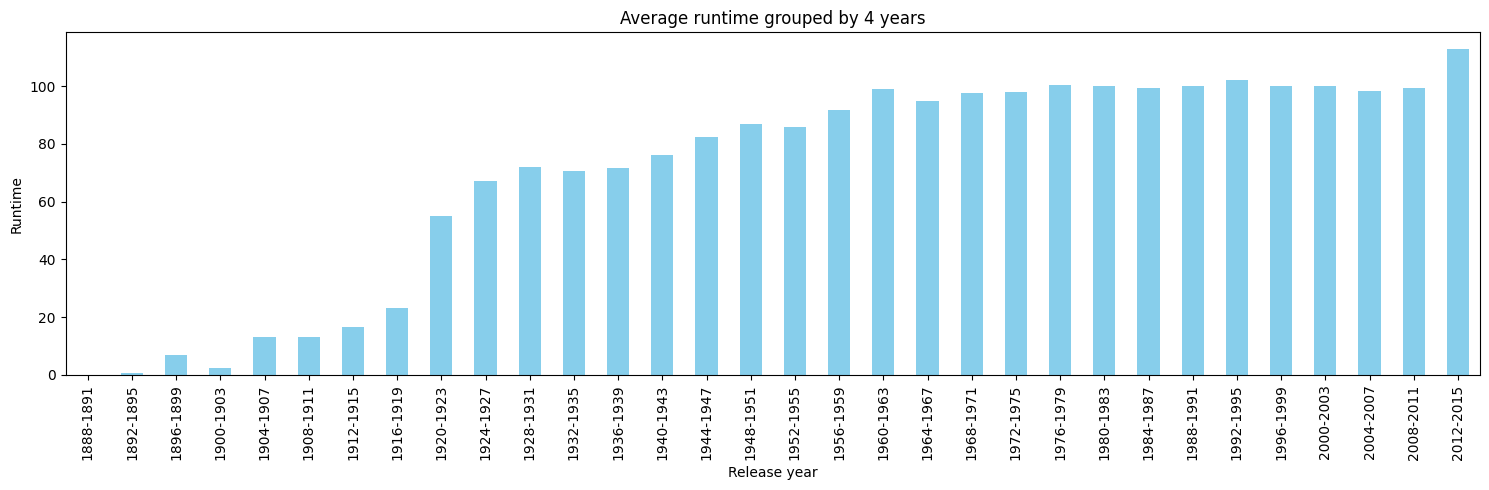

In [25]:
movies_year_runtime = MOVIES.groupby("release_year")["runtime"].median()

bin_size = 4
binned_runtimes = {}

for i in range(FIRST_MOVIE_YEAR, int(movies_year_runtime.index.max()), bin_size):
    bin_start, bin_end = i, i + bin_size - 1
    
    # Calculate the mean runtime within the current year range (bin)
    total_in_bin = movies_year_runtime[
        (movies_year_runtime.index >= bin_start) & 
        (movies_year_runtime.index <= bin_end)
    ].median()
    
    # Store result in dictionary with bin label as key
    binned_runtimes[f'{bin_start}-{bin_end}'] = total_in_bin

binned_token_counts = pd.Series(binned_runtimes)

# Plot
plt.figure(figsize=(15, 5))
binned_token_counts.plot(kind='bar', color='skyblue')

plt.xlabel('Release year')
plt.ylabel('Runtime')
plt.title(f'Average runtime grouped by {bin_size} years')

plt.tight_layout()
plt.show()

### Genre runtime analysis

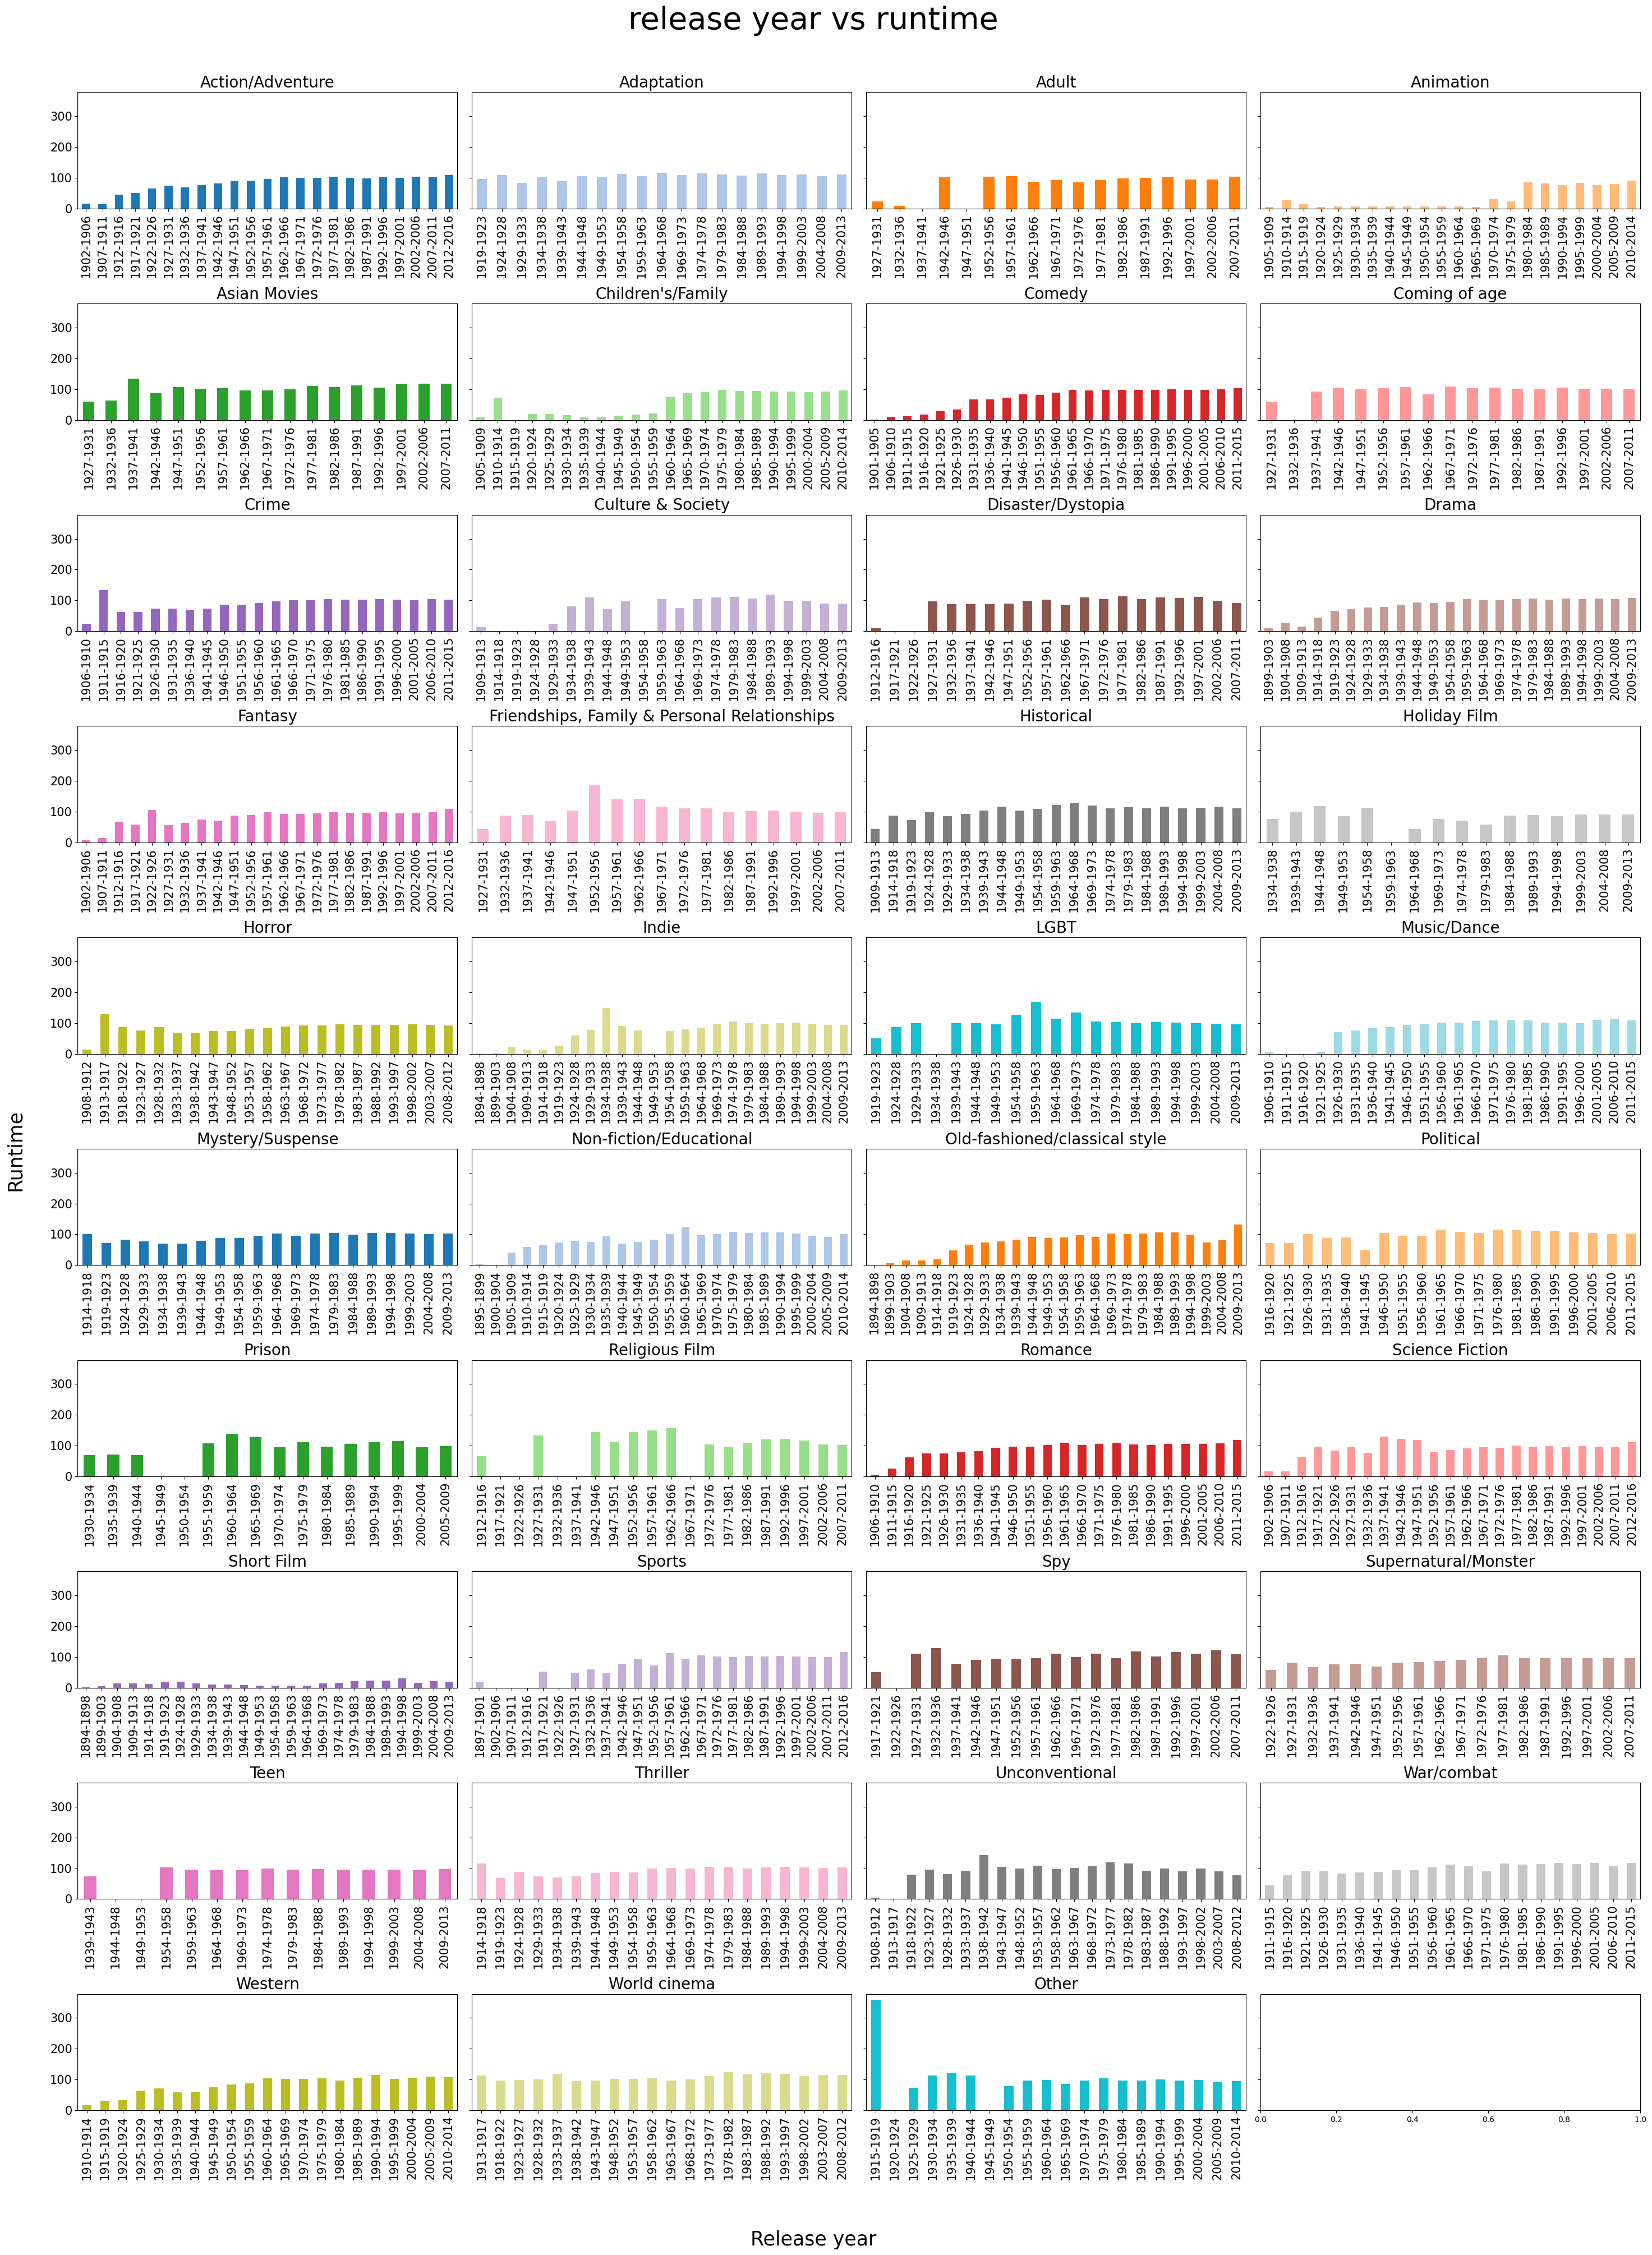

In [26]:
unique_genre = NEW_GENRE["categories"]


fig, axes = plt.subplots(10, 4, figsize=(30, 40), sharey = True)
#fig.delaxes(axes[4, 3])
colors = sns.color_palette("tab20", len(unique_genre))
color_iter = iter(colors)

for j, genre in enumerate(unique_genre):

    df_filtered = MOVIES[MOVIES["new_genres"].apply(lambda x: genre in x)]
    bin_size = 5
    movies_year_runtime = df_filtered.groupby("release_year")["runtime"].median()
    binned_counts = {}
    for i in range(movies_year_runtime.index.min(), movies_year_runtime.index.max(), bin_size):
        bin_start, bin_end = i, i + bin_size - 1
        
        # Sum all the runtimes counts in this range.
        total_in_bin = movies_year_runtime[(movies_year_runtime.index >= bin_start) & (movies_year_runtime.index <= bin_end)].mean()
        
        binned_counts[f'{bin_start}-{bin_end}'] = total_in_bin


    binned_token_counts = pd.Series(binned_counts)
    color = next(color_iter)
    ax = axes[j//4, j%4]
    binned_token_counts.plot(kind='bar', ax=ax, color=color, fontsize=15)

    ax.set_title(genre, size = 20)
fig.supxlabel('Release year', size = 25)
fig.supylabel('Runtime', size = 25)
fig.suptitle('release year vs runtime', size = 40, y=1.01)
fig.tight_layout(rect=(0.025,0.025,1,1))

Text(0.5, 1.0, 'Genre vs runtime')

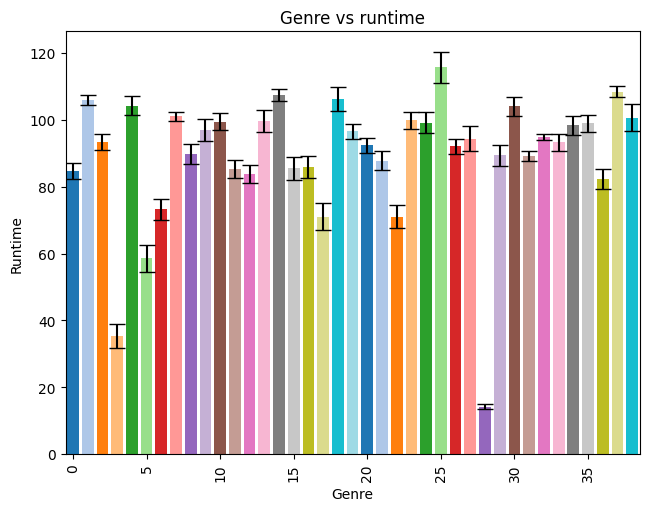

In [31]:
fig, ax = plt.subplots()
colors = sns.color_palette("tab20", len(unique_genre))
color_iter = iter(colors)
average = []
std = []
number_of_year_to_average = 5

for idx, genre in enumerate(unique_genre):

    df_filtered = MOVIES[MOVIES["new_genres"].apply(lambda x: genre in x)]
    medians = df_filtered.groupby("release_year")["runtime"].median()
    average.append(medians.mean())
    std.append(medians.std()/np.sqrt(medians.size))
    
ax.tick_params(axis='x', labelrotation=90)
for i in range(len(unique_genre)):
    color = next(color_iter)
    ax.bar(list(unique_genre.keys())[i], average[i], color=color)
    ax.errorbar(list(unique_genre.keys())[i], average[i], yerr=std[i],capsize=6,  color = 'k')
    
ax.set_xlim(-0.5, len(unique_genre) - 0.5) # Set limits to avoid extra space on sides
plt.tight_layout()
ax.set_xlabel("Genre")
ax.set_ylabel("Runtime")
ax.set_title("Genre vs runtime")

### Genre revenue analysis

Text(0.5, 1.0, 'Genre vs revenue')

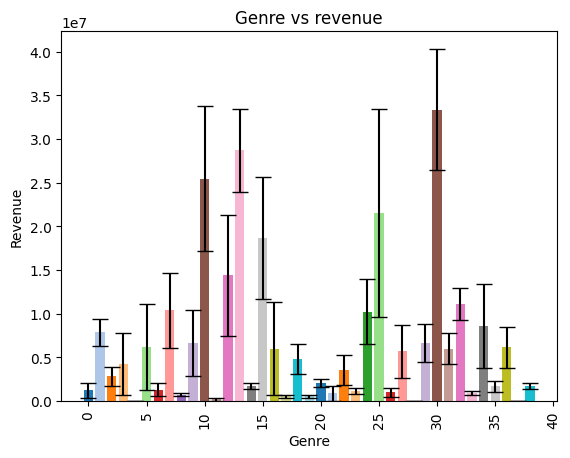

In [ ]:
fig, ax = plt.subplots()
colors = sns.color_palette("tab20", len(unique_genre))
color_iter = iter(colors)
average = []
std = []
number_of_year_to_average = 5

for idx, genre in enumerate(unique_genre):

    df_filtered = MOVIES[MOVIES["new_genres"].apply(lambda x: genre in x)]
    group =  df_filtered.groupby("release_year")["revenue"].median()
    average.append(group.mean())
    std.append(group.std()/np.sqrt(group.size))
    
ax.tick_params(axis='x', labelrotation=90)
for i in range(len(unique_genre)):
    color = next(color_iter)
    ax.bar(list(unique_genre.keys())[i], average[i], color=color)
    ax.errorbar(list(unique_genre.keys())[i], average[i], yerr=std[i],capsize=6,  color = 'k')
    """ FIX SOMETHING"""

ax.set_xlabel("Genre")
ax.set_ylabel("Revenue")
ax.set_title("Genre vs revenue")

### SCATTER PLOT YEAR VS BUDGET :D

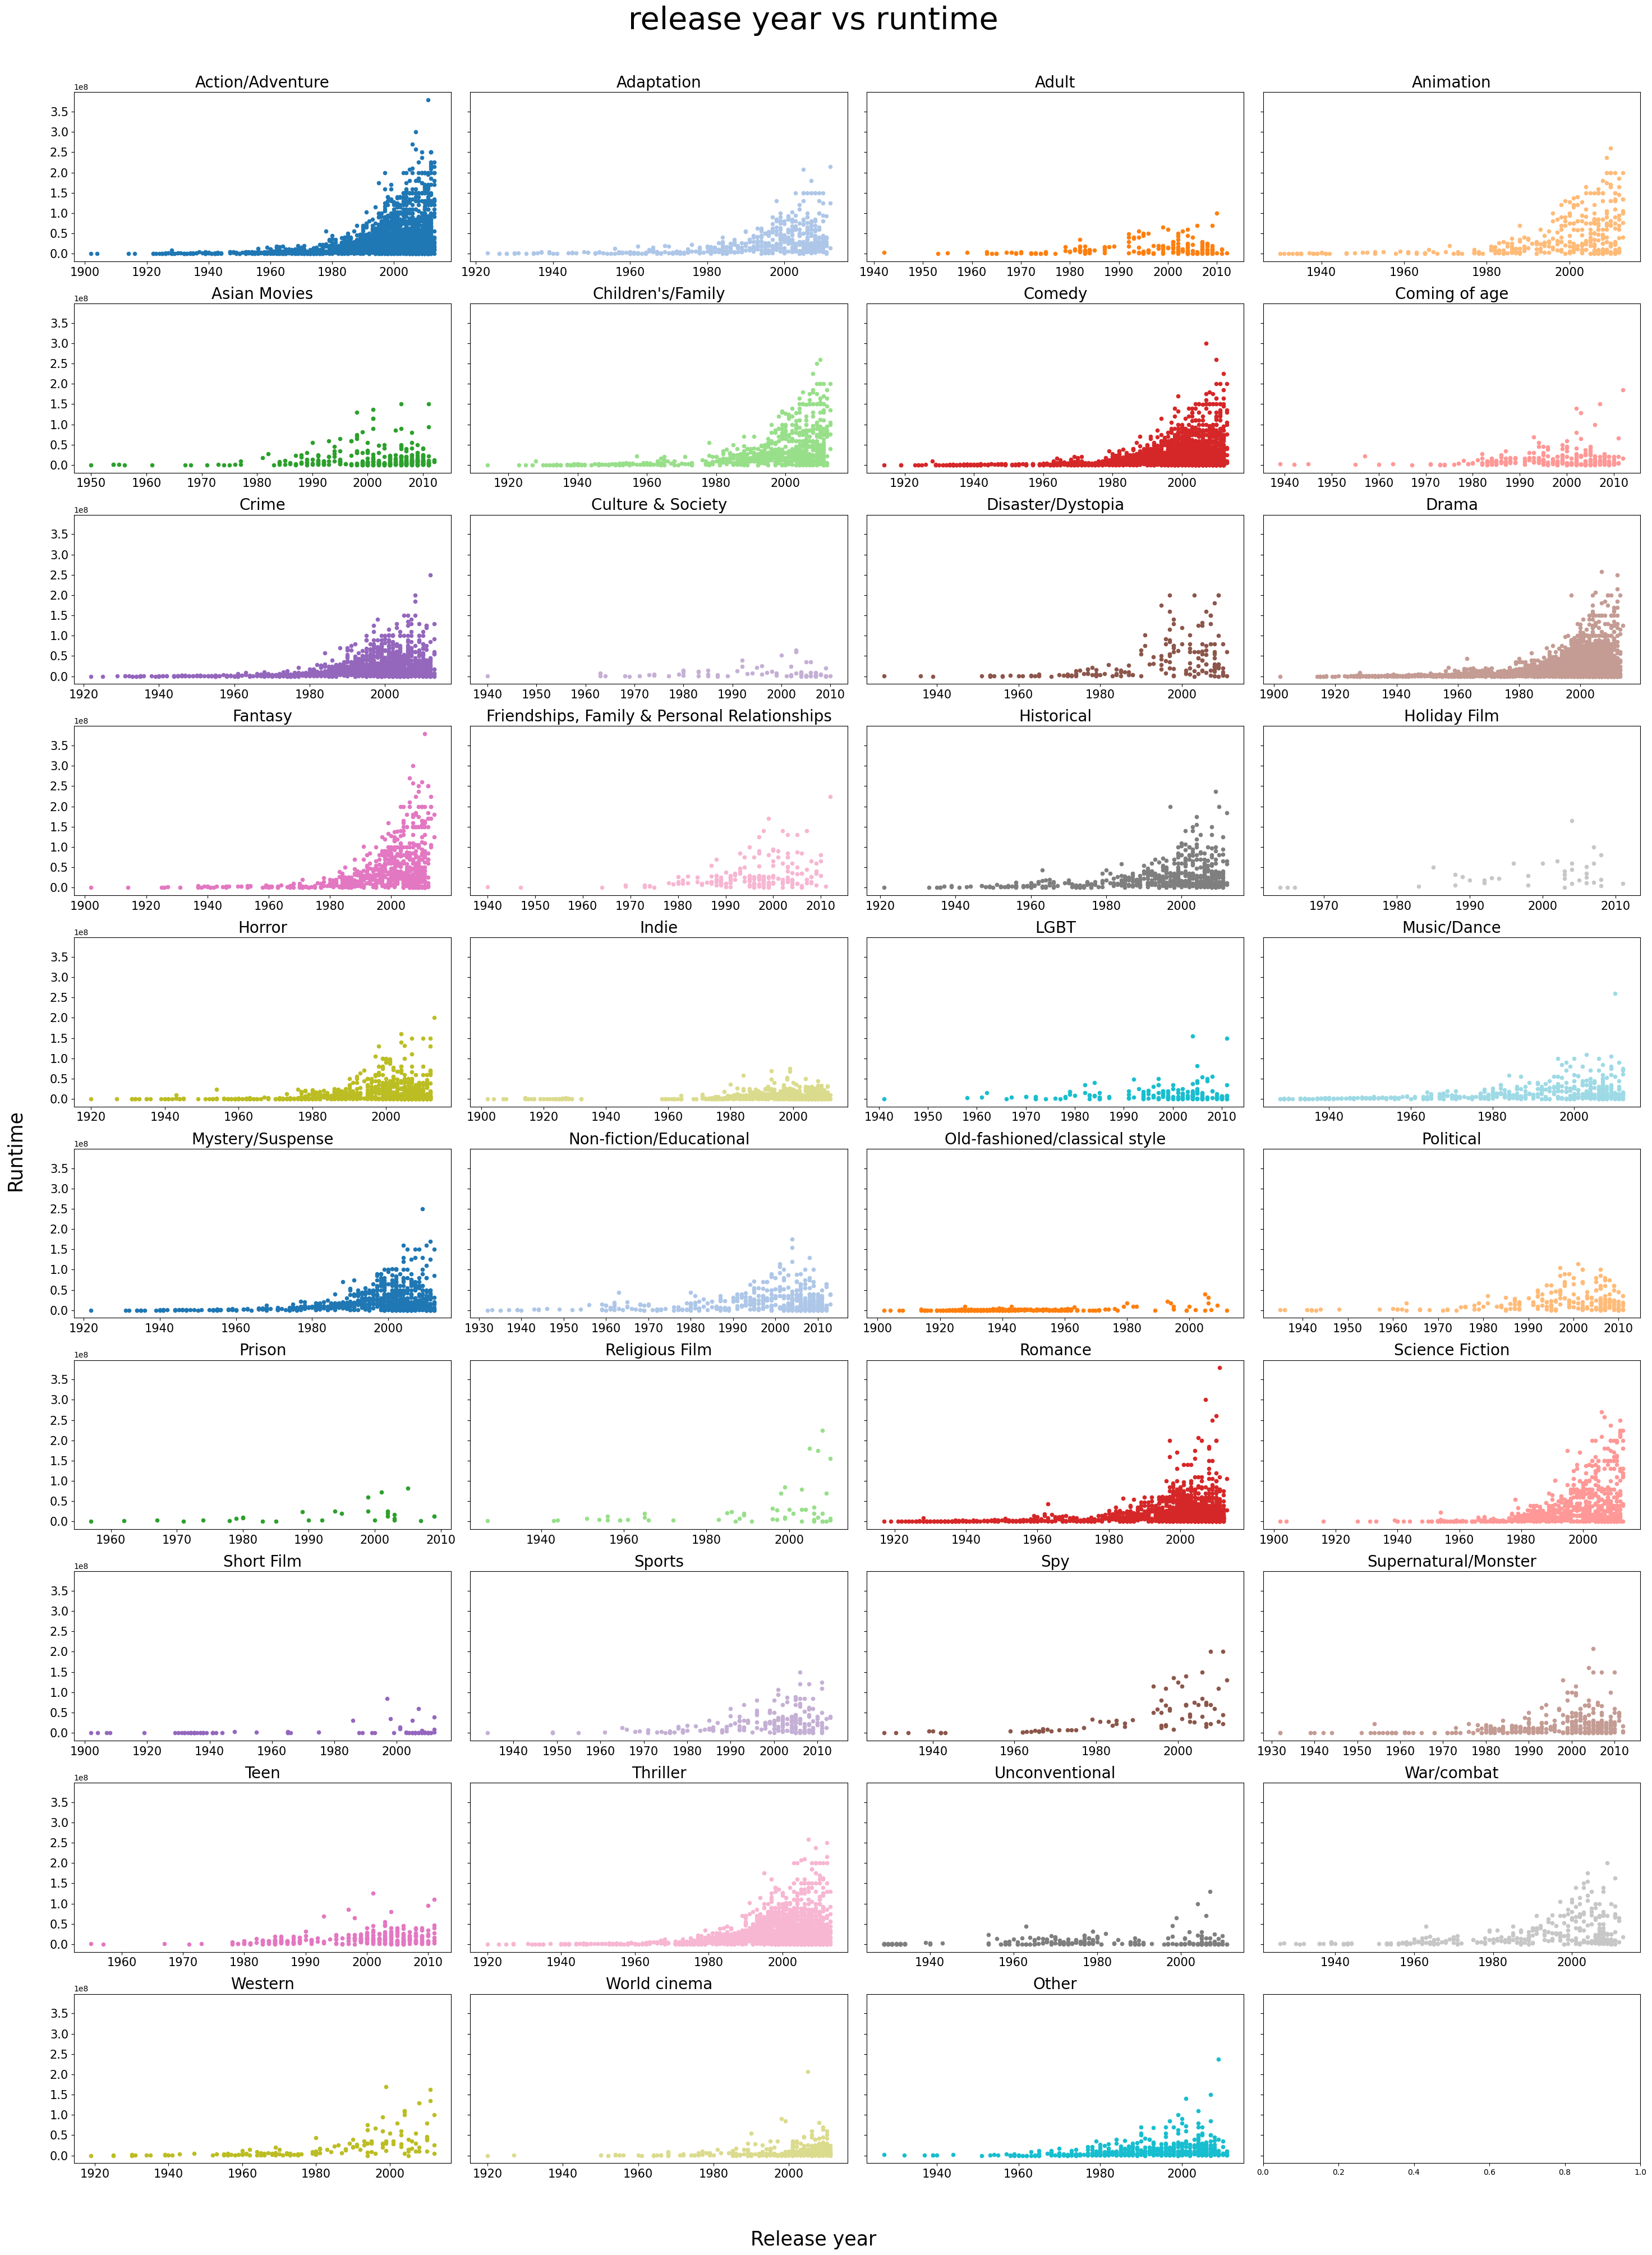

In [87]:
pd.options.mode.chained_assignment = None  # default='warn'

unique_genre = NEW_GENRE["categories"]


fig, axes = plt.subplots(10, 4, figsize=(30, 40), sharey = True)
#fig.delaxes(axes[4, 3])
colors = sns.color_palette("tab20", len(unique_genre))
color_iter = iter(colors)

for j, genre in enumerate(unique_genre):

    df_filtered = MOVIES[MOVIES["new_genres"].apply(lambda x: genre in x)]
    df_filtered.dropna(subset=["budget"], inplace=True)
    df_filtered['budget'] = df_filtered['budget'].astype(int)
    df_filtered = df_filtered[df_filtered['budget'] != 0]
    color = next(color_iter)
    ax = axes[j//4, j%4]
    df_filtered.plot.scatter(x='release_year', y='budget', ax=ax, color=color, fontsize=15)
    ax.set_xlabel("")
    ax.set_ylabel("")

    ax.set_title(genre, size = 20)
fig.supxlabel('Release year', size = 25)
fig.supylabel('Runtime', size = 25)
fig.suptitle('release year vs runtime', size = 40, y=1.01)
fig.tight_layout(rect=(0.025,0.025,1,1))

### HEATMAP (╯°□°)╯︵ ┻━┻

39


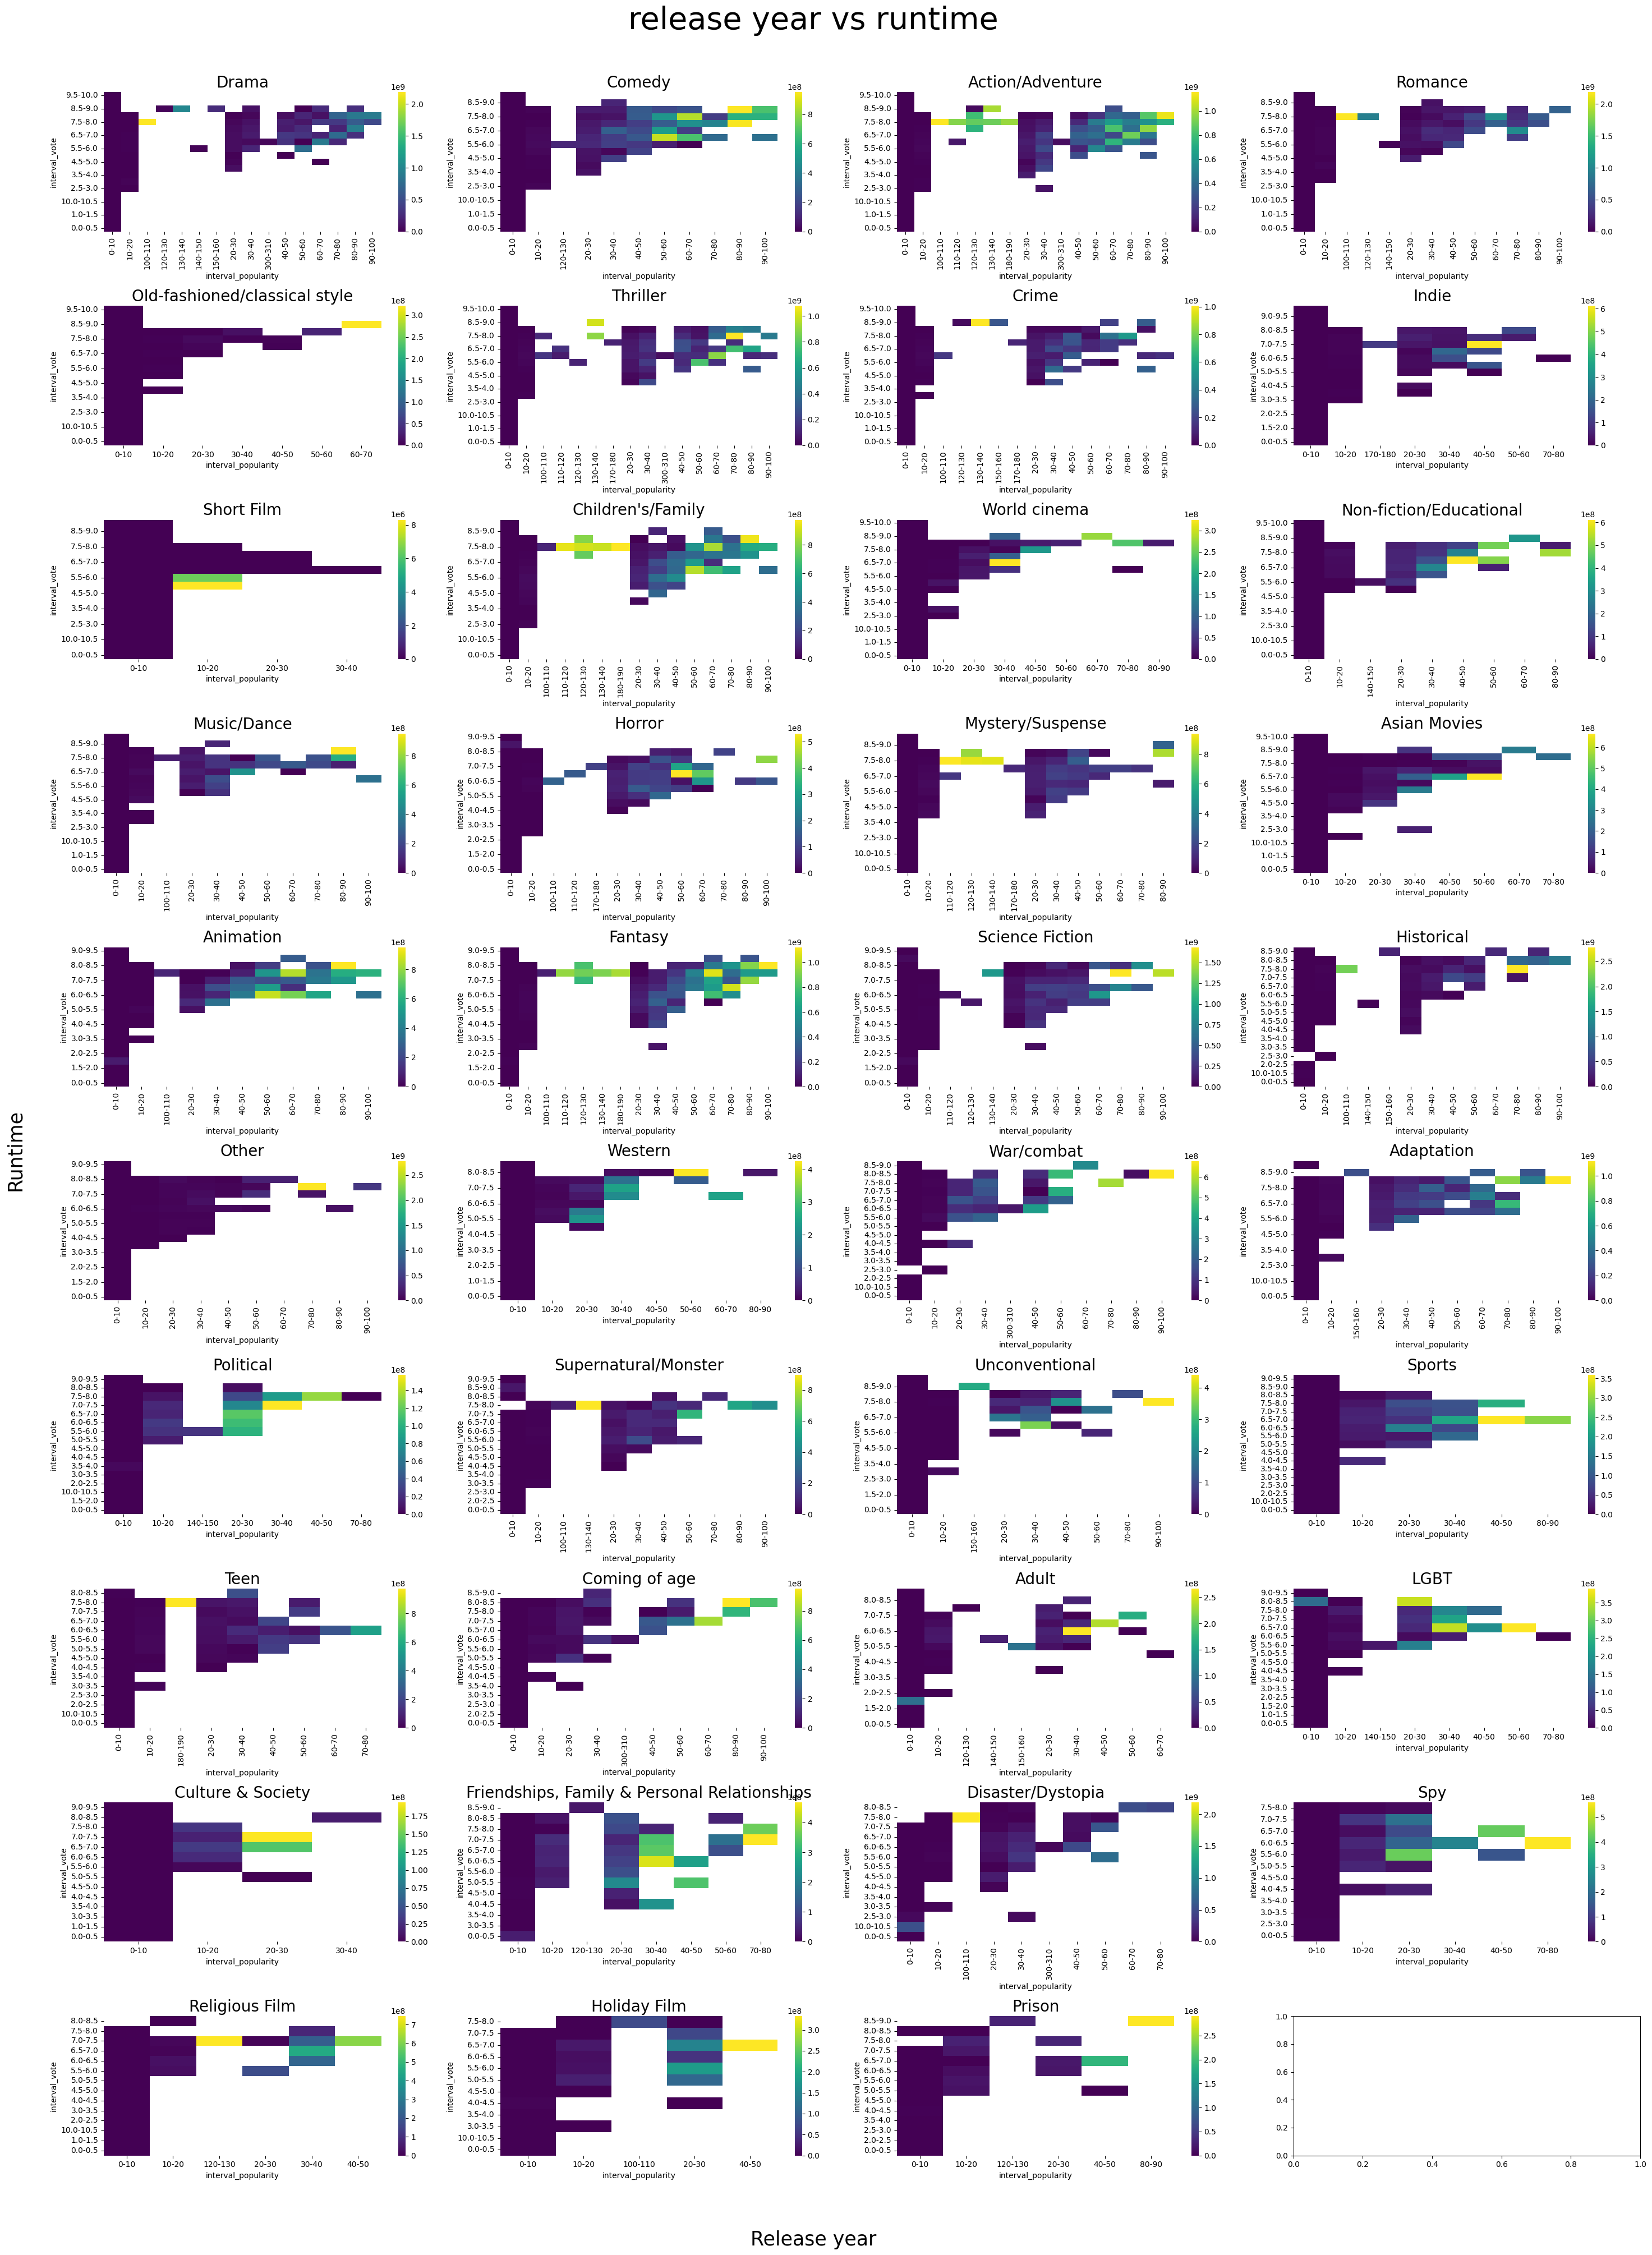

In [93]:
pd.options.mode.chained_assignment = None  # default='warn'

# unique_genre = MOVIES["new_genres"]
unique_genre = list()
MOVIES["new_genres"].apply(lambda x: unique_genre.extend(x))
unique_genre = Counter(unique_genre)
print(len(unique_genre))
unique_genre = {k: v for k, v in sorted(unique_genre.items(), key=lambda item: item[1], reverse=True)}
unique_genre = {k: unique_genre[k] for k in list(unique_genre)}
#unique_genre = {x:unique_genre[x] for x in unique_genre if unique_genre[x] >= 300}


fig, axes = plt.subplots(10, 4, figsize=(30, 40))
#fig.delaxes(axes[4, 3])
colors = sns.color_palette("tab20", len(unique_genre))
color_iter = iter(colors)

for j, genre in enumerate(unique_genre):
    

    df_filtered = MOVIES[MOVIES["new_genres"].apply(lambda x: genre in x)]
    df_filtered['interval_vote'] = df_filtered['vote_average'].astype(float).apply(lambda x: f'{int(x/0.5)*0.5}-{int(x/0.5+1)*0.5}')
    df_filtered['interval_popularity'] = df_filtered['popularity'].astype(float).apply(lambda x: f'{int(x/10)*10}-{int(x/10+1)*10}')
    df_temp = pd.crosstab(df_filtered['interval_vote'], df_filtered['interval_popularity'], values = df_filtered['revenue'],
                  margins=False, aggfunc='median')

    color = next(color_iter)
    ax = axes[j//4, j%4]
    sns.heatmap(df_temp, annot=False, ax=ax, cmap='viridis')
    ax.invert_yaxis()
    ax.set_title(genre, size = 20)
    

fig.supxlabel('Release year', size = 25)
fig.supylabel('Runtime', size = 25)
fig.suptitle('release year vs runtime', size = 40, y=1.01)
fig.tight_layout(rect=(0.025,0.025,1,1))

39


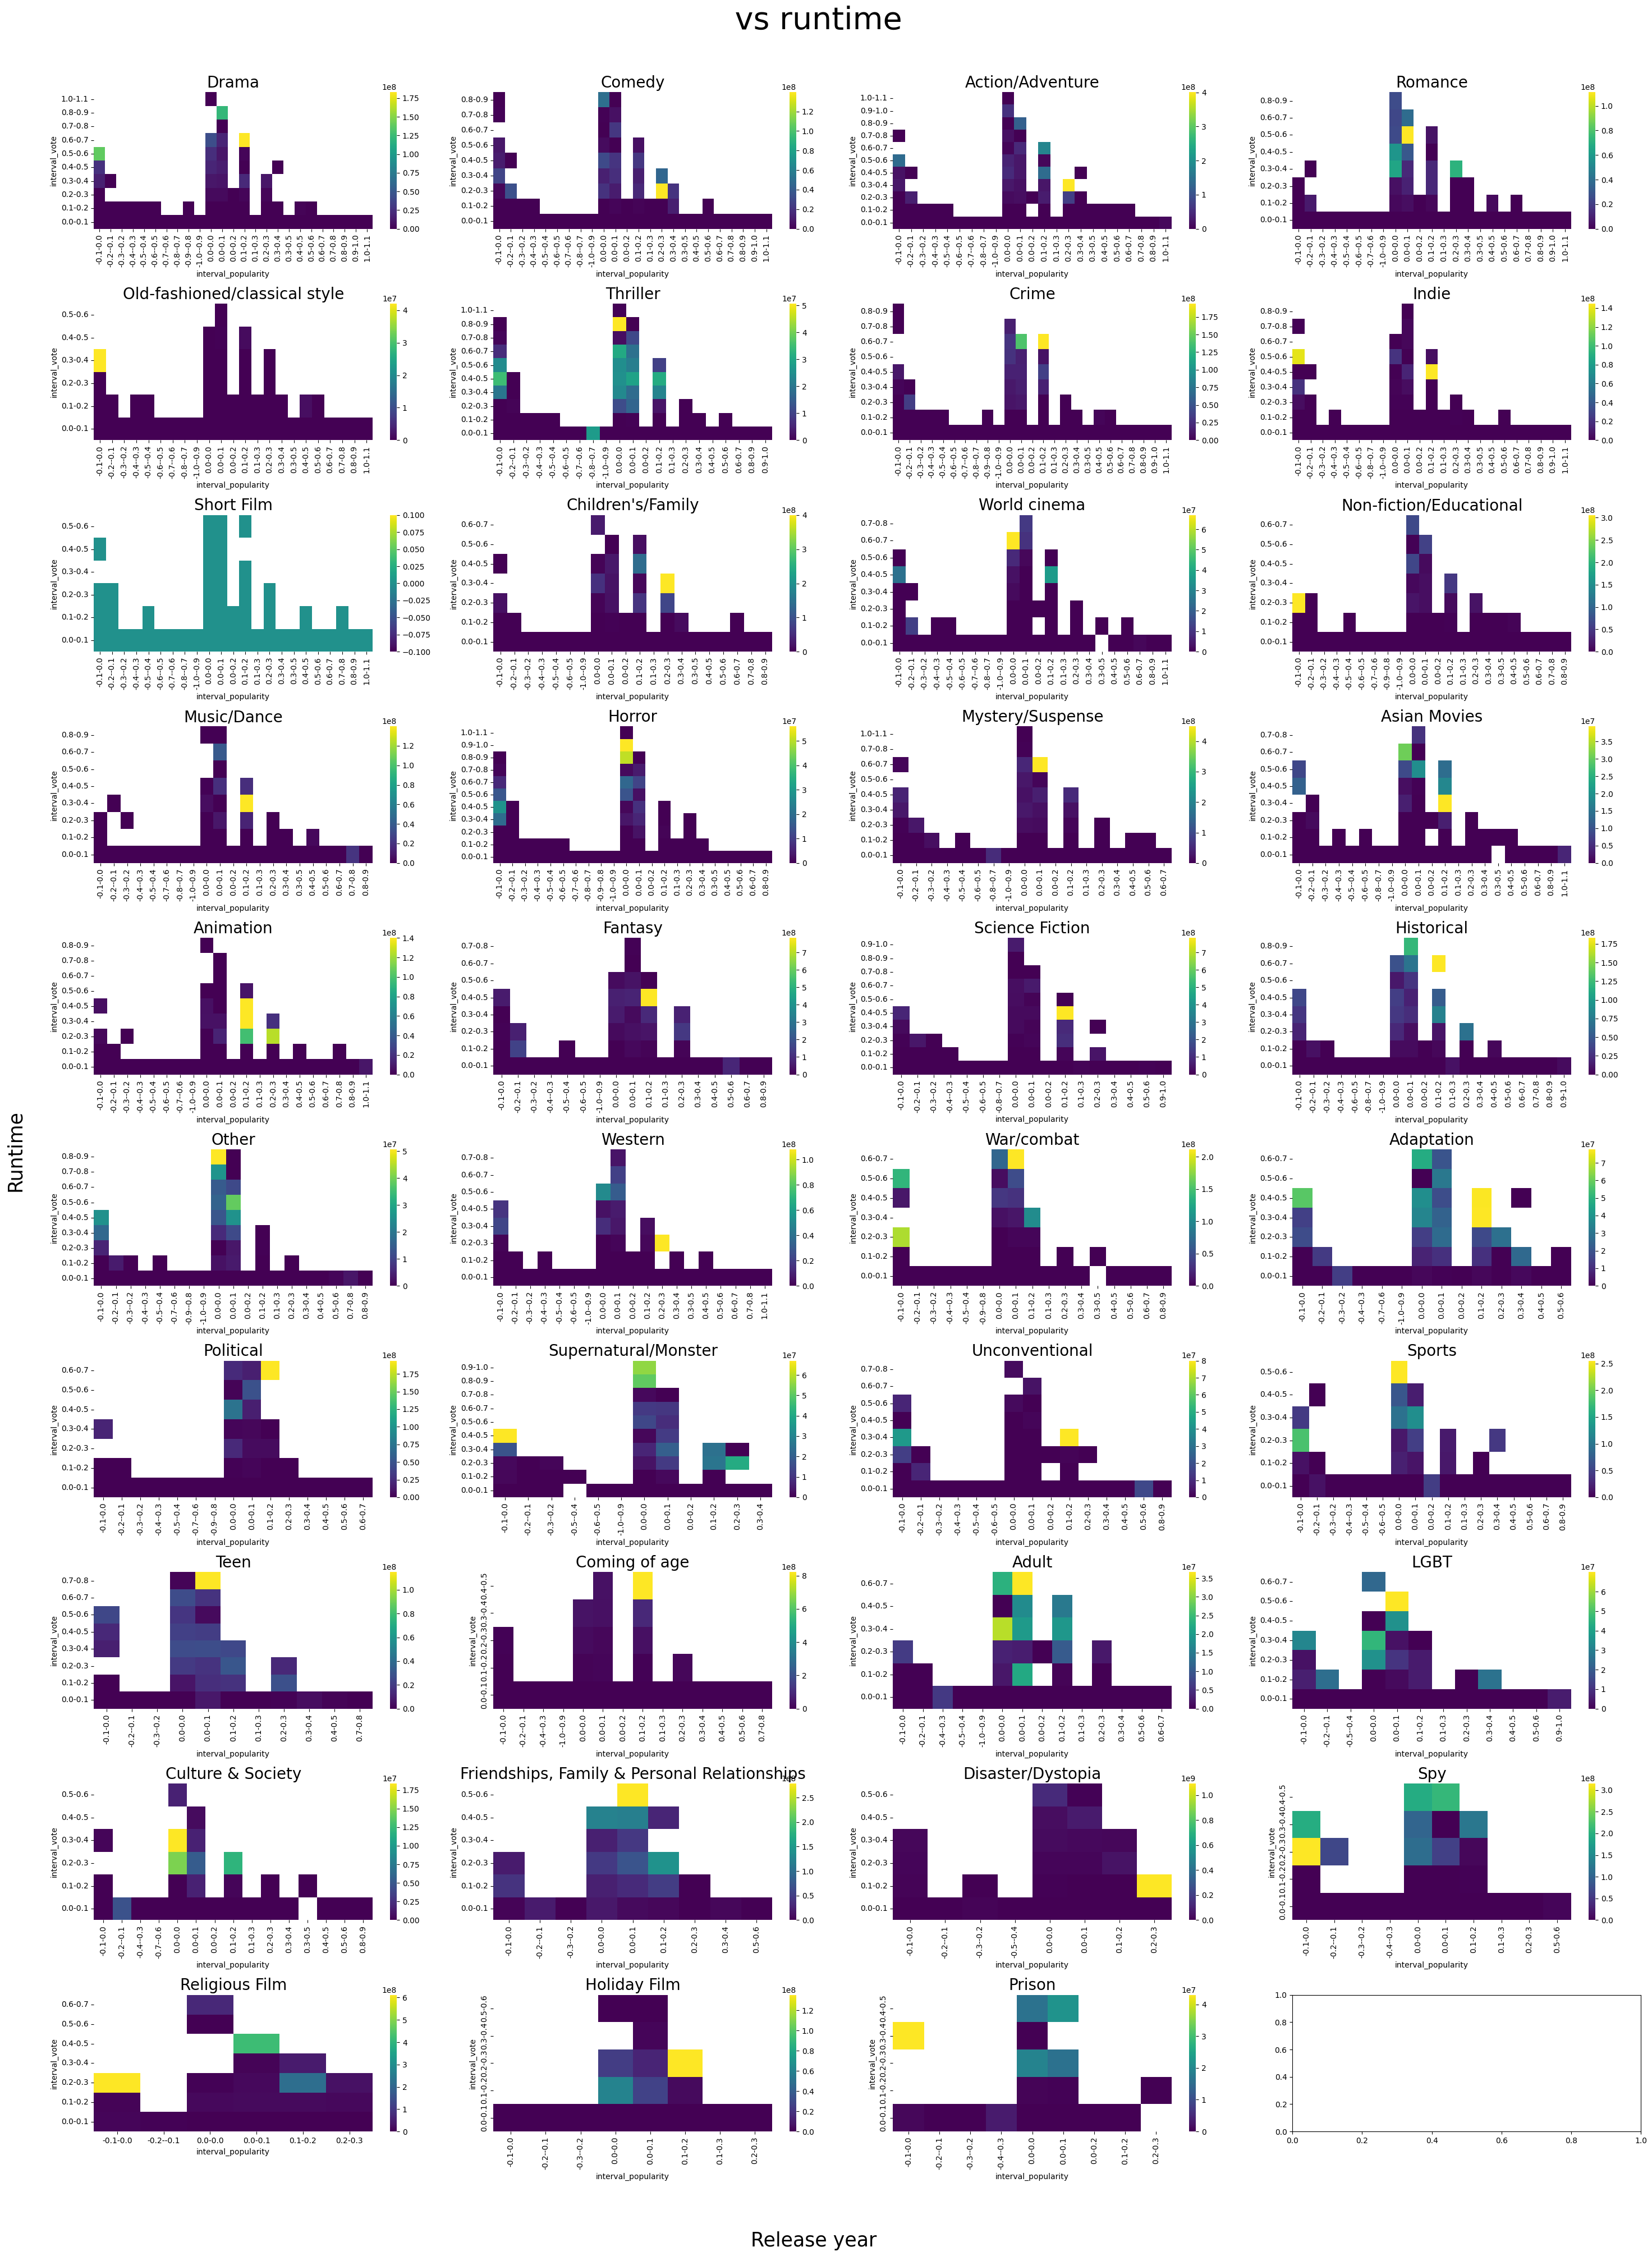

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'

# unique_genre = MOVIES["new_genres"]
unique_genre = list()
MOVIES["new_genres"].apply(lambda x: unique_genre.extend(x))
unique_genre = Counter(unique_genre)
print(len(unique_genre))
unique_genre = {k: v for k, v in sorted(unique_genre.items(), key=lambda item: item[1], reverse=True)}
unique_genre = {k: unique_genre[k] for k in list(unique_genre)}
#unique_genre = {x:unique_genre[x] for x in unique_genre if unique_genre[x] >= 300}


fig, axes = plt.subplots(10, 4, figsize=(30, 40))
#fig.delaxes(axes[4, 3])
colors = sns.color_palette("tab20", len(unique_genre))
color_iter = iter(colors)

for j, genre in enumerate(unique_genre):
    

    df_filtered = MOVIES[MOVIES["new_genres"].apply(lambda x: genre in x)]
    df_filtered['interval_vote'] = df_filtered['death_theme'].astype(float).apply(lambda x: f'{int(x/0.1)*0.1:.1f}-{int(x/0.1+1)*0.1:.1f}')
    df_filtered['interval_popularity'] = df_filtered['sentiment'].astype(float).apply(lambda x: f'{int(x/0.1)*0.1:.1f}-{int(x/0.1+1)*0.1:.1f}')
    df_temp = pd.crosstab(df_filtered['interval_vote'], df_filtered['interval_popularity'], values = df_filtered['revenue'],
                  margins=False, aggfunc='median')

    color = next(color_iter)
    ax = axes[j//4, j%4]
    sns.heatmap(df_temp, annot=False, ax=ax, cmap='viridis')
    ax.invert_yaxis()
    ax.set_title(genre, size = 20)
    

fig.supxlabel('Sentiment', size = 25)
fig.supylabel('Death theme', size = 25)
fig.suptitle('Death theme vs Sentimen vs Revenue', size = 40, y=1.01)
fig.tight_layout(rect=(0.025,0.025,1,1))

Semtiment makes no different on the revenue but death topics do

# MOVIE GENRE PREDICTOR MODEL

### Data spliting and cross validation definition

In [97]:
def cross_validation_split(data, training_columns, testing_column, set_to_test, train_proportion = 0.2, seed = 42):
    divisions = int(1 / train_proportion)
    if set_to_test is None or set_to_test > divisions or set_to_test < 0:
        print("BE CAREFUL, ONLY VALUES FORM 0 to 1. Setting testing set to 0")
        set_to_test = 0
    # GET THE MOST FROM THE UNBALANCED CLASS
    train_proportion = train_proportion # 1/train_proportion divisioins, as default 2
    n = np.round(train_proportion, 0).astype(int)
        
    data_suffled = data.sample(frac=1, random_state=seed).reset_index(drop=True)
    training_set = data_suffled[:n*set_to_test] + data_suffled[n*(set_to_test+1):] 
    testing_set = data_suffled[n*set_to_test:n*(set_to_test+1)]

    return (
        training_set[training_columns], 
        training_set[testing_column], 
        testing_set[training_columns], 
        testing_set[testing_column], 
    )

def train_and_test_split(data, training_columns, testing_column, train_proportion = 0.2, seed = 42):
    training_set, testing_set = train_test_split(data, test_size=train_proportion, random_state=seed)

    return (
        training_set[training_columns], 
        training_set[testing_column], 
        testing_set, 
        testing_set[testing_column], 
    )

In [98]:
MOVIES.columns

Index(['wikipedia_movie_ID', 'name', 'release_date', 'revenue', 'runtime',
       'languages', 'countries', 'genres', 'release_year', 'vote_average',
       'vote_count', 'adult', 'budget', 'popularity', 'plot',
       'original_genres', 'new_genres', 'genre_hot', 'sentiment'],
      dtype='object')

In [99]:
training_columns = ["revenue", "runtime", "release_year",  "vote_average", "vote_count", "adult", "budget", "popularity", "sentiment"] # "death_theme"
target_column = ["genre_hot"]
#set_to_test = SETTINGS["MODEL_SETTINGS"]["TEST_SET"]
training_set, training_target_set, testing_set, testing_target_set = train_and_test_split(MOVIES, training_columns, target_column, train_proportion =  SETTINGS["MODEL_SETTINGS"]["TEST_PROPORTION"],seed = SETTINGS["MODEL_SETTINGS"]["SEED"],)

### Model definition

In [100]:
get_model = lambda feature_size, genre_size, layer_size: torch.nn.Sequential(
    # Input layer
    torch.nn.Linear(feature_size, layer_size),
    torch.nn.ReLU(),
    
    # Hidden layers
    torch.nn.Linear(layer_size, layer_size),
    torch.nn.ReLU(),
    torch.nn.Linear(layer_size, layer_size),
    torch.nn.ReLU(),
    torch.nn.Linear(layer_size, layer_size),
    torch.nn.ReLU(),
    
    # Output layer
    torch.nn.Linear(layer_size, genre_size),
    torch.nn.Sigmoid() # To get probabilities
)

### Model instance

In [101]:
feature_size = len(training_columns)
genre_size = len(NEW_GENRE["subgenres"])

model_factory = lambda: get_model(feature_size, genre_size, SETTINGS["MODEL_SETTINGS"]["LAYER_SIZE"])
model = model_factory()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device=device)

optimizer_kwargs = dict(
    lr=3e-4,
    weight_decay=1e-3,
)
optimizer = torch.optim.AdamW(model.parameters(), **optimizer_kwargs)

### Model training

In [102]:
def train_model(batches_train, batches_test, model, optimizer, classification_threshold, device):
    # Set model to training mode 
    model.train()

    loss_history = []
    accuracy_history = []
    f_score_history = []
    precision_history = []
    recall_history = []
    # Change the loop to get batch_idx, data and target from train_loader
    for sample_i, (data, target) in enumerate(zip(batches_train, batches_test)):
        target = target.squeeze(1)
        N = data.shape[0] 
        Dy = target.shape[1] # Number of possible genre 
        
        # Move the data to the device
        data = data.float().to(device)
        target = target.float().to(device)
        
        optimizer.zero_grad()
        output = model(data)
        
        loss = torch.nn.BCELoss()(output, target)
        loss_float = loss.item()
        # Backpropagate loss & Perform an optimizer step
        loss.backward()
        optimizer.step()
        
        
        # Compute accuracy and loss of the batch
        output_hot, correct = get_output_hot(output, target, classification_threshold)
        accuracy = correct.item() / (N * Dy) 
        f_score, precision, recall = compute_avg_f_score(output_hot, target)
        
        accuracy_history.append(accuracy)
        loss_history.append(loss_float)
        f_score_history.append(f_score)
        precision_history.append(precision)
        recall_history.append(recall)
        
        del data
        del target
        
        if sample_i % (1000 // N) == 0: # Every 1000 samples
            print(f'Batch {loss_float = :.3f}')
            print(f'Batch {accuracy = :.3f}')
            print(f'Batch {f_score = :.3f}')
            print(f'Batch {precision = :.3f}')
            print(f'Batch {recall = :.3f}')
    # print(f"{loss_history = }, {accuracy_history = }")
    torch.cuda.empty_cache()
    return model, loss_history, accuracy_history, f_score_history, precision_history, recall_history

def get_output_hot(output, target, classification_threshold):
    output_hot = (output > classification_threshold).int() # we have |N| x |genre| matrix
    correct = torch.sum(output_hot == target)

    return output_hot, correct

def compute_avg_f_score(output_hot, target):
    target = target.int()
    # print(f"{output_hot = }")
    # print(f"{target = }")
    true_positives = torch.sum((output_hot & target), dim = 1)
    false_positives = torch.sum((output_hot & ~target), dim = 1)
    false_negatives = torch.sum((~output_hot & target), dim = 1)
    
    denominator = true_positives + false_positives
    precision = torch.where(denominator > 0,
                            true_positives / denominator,
                            torch.zeros_like(true_positives)
                            )
    
    denominator = true_positives + false_negatives
    recall = torch.where(denominator > 0,
                         true_positives / denominator,
                         torch.zeros_like(true_positives)
                         )
    
    denominator = precision + recall
    f_score = torch.where(denominator > 0,
                          2*(precision * recall) / denominator,
                          torch.zeros_like(true_positives)
                          )
                          
    return torch.mean(f_score).item(), torch.mean(precision).item(), torch.mean(recall).item()

We use stochastic training for better performance. The batch size is 10 by default.

In [103]:
def get_training_batch(training_set, target_set, batch_size = 10):
    assert len(training_set) == len(target_set), "Lists must be of equal length."
    
    batches_train = []
    batches_test = []
    for i in range(0, len(training_set), batch_size):
        batches_train.append(torch.tensor(training_set.iloc[i:i+batch_size].values, dtype=torch.float64))
        batches_test.append(torch.tensor(target_set.iloc[i:i+batch_size].values.tolist()))
        
    return batches_train, batches_test

In [104]:
batches_train, batches_test = get_training_batch(training_set, training_target_set)
# print(f"{batches_train = }")
# print(f"{batches_test = }")

trained_model, train_loss, train_acc, f_score_history, precision_history, recall_history = train_model(
    batches_train, batches_test, model, optimizer, SETTINGS["MODEL_SETTINGS"]["GENRE_THRESHOLD"], device
) 

Batch loss_float = 20.446
Batch accuracy = 0.426
Batch f_score = 0.150
Batch precision = 0.087
Batch recall = 0.703
Batch loss_float = 3.032
Batch accuracy = 0.910
Batch f_score = 0.340
Batch precision = 0.600
Batch recall = 0.262
Batch loss_float = 6.576
Batch accuracy = 0.885
Batch f_score = 0.000
Batch precision = 0.000
Batch recall = 0.000
Batch loss_float = 8.088
Batch accuracy = 0.879
Batch f_score = 0.082
Batch precision = 0.121
Batch recall = 0.100
Batch loss_float = 7.982
Batch accuracy = 0.854
Batch f_score = 0.000
Batch precision = 0.000
Batch recall = 0.000
Batch loss_float = 5.038
Batch accuracy = 0.897
Batch f_score = 0.190
Batch precision = 0.400
Batch recall = 0.128
Batch loss_float = 1.677
Batch accuracy = 0.941
Batch f_score = 0.200
Batch precision = 0.300
Batch recall = 0.170
Batch loss_float = 10.340
Batch accuracy = 0.867
Batch f_score = 0.188
Batch precision = 0.231
Batch recall = 0.183
Batch loss_float = 8.543
Batch accuracy = 0.879
Batch f_score = 0.020
Batch pr

### Training Plotting

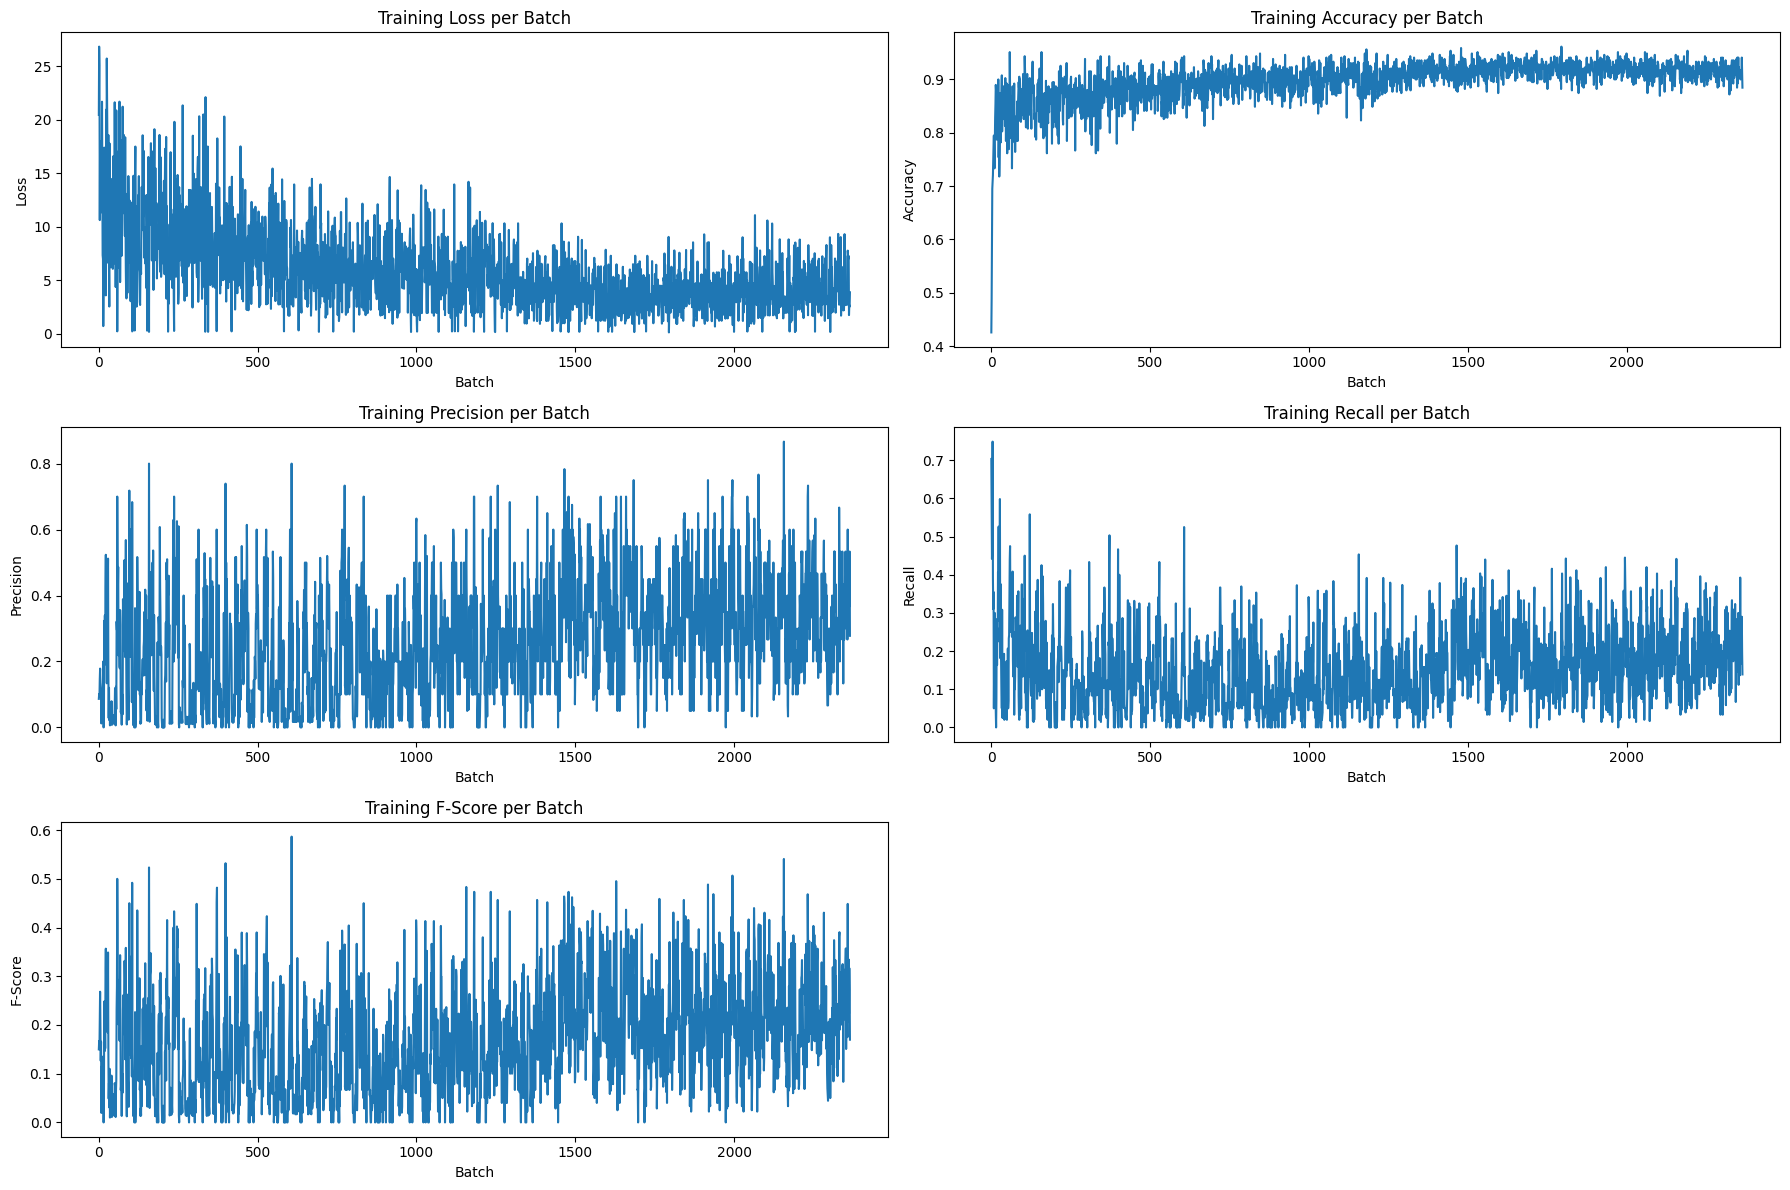

In [105]:
batch_indices = [i for i in range(len(batches_train))]

plt.figure(figsize=(18, 12)) 

plt.subplot(3, 2, 1)
plt.plot(batch_indices, train_loss)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Training Loss per Batch")

plt.subplot(3, 2, 2)
plt.plot(batch_indices, train_acc)
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy per Batch")

plt.subplot(3, 2, 3)
plt.plot(batch_indices, precision_history)
plt.xlabel("Batch")
plt.ylabel("Precision")
plt.title("Training Precision per Batch")

plt.subplot(3, 2, 4)
plt.plot(batch_indices, recall_history)
plt.xlabel("Batch")
plt.ylabel("Recall")
plt.title("Training Recall per Batch")

plt.subplot(3, 2, 5)
plt.plot(batch_indices, f_score_history)
plt.xlabel("Batch")
plt.ylabel("F-Score")
plt.title("Training F-Score per Batch")

plt.tight_layout()
plt.show()

In [106]:
del batches_train
del batches_test
del training_set
del training_target_set
del train_loss
del train_acc
del precision_history
del recall_history
del f_score_history
torch.cuda.empty_cache()

### Model testing

In [ ]:
def test_model(model, testing_set, testing_target_set, classification_threshold):
    N = testing_set.shape[0] 
    Dy = testing_target_set.shape[1] 
    
    with torch.no_grad():
        output = model(testing_set)
        
    del testing_set
        
    output_hot, correct = get_output_hot(output, testing_target_set, classification_threshold)
    
    f_score, precision, recall = compute_avg_f_score(output_hot, testing_target_set)
    
    accuracy = correct.item() / (N * Dy) 
    
    print(f'Testing {accuracy = :.3f}')
    print(f'Testing {f_score = :.3f}')
    print(f'Testing {precision = :.3f}')
    print(f'Testing {recall = :.3f}')
    
    return output_hot
    

In [114]:
testing_set_t = torch.tensor(testing_set[training_columns].values.tolist(), dtype=torch.float32).to(device)
testing_target_set_t = torch.tensor(testing_target_set.values.tolist(), dtype=torch.float32).to(device)

predictions = test_model(trained_model, testing_set_t, testing_target_set_t, SETTINGS["MODEL_SETTINGS"]["GENRE_THRESHOLD"])

genre_labels = NEW_GENRE["categories"]
predicted_genre = []

for movie_prediction in predictions:
    genres = [genre_labels[i] for i, is_genre in enumerate(movie_prediction) if is_genre == 1]
    predicted_genre.append(genres)

predictins_output = pd.DataFrame({
    'wikipedia_movie_ID': testing_set["wikipedia_movie_ID"],
    'name': testing_set["name"],
    'original_genres': testing_set["new_genres"],
    'predicted_genres': predicted_genre,
})


predictins_output.to_csv("movies_predicted_genre.csv", index = False)


5914


OutOfMemoryError: CUDA out of memory. Tried to allocate 10.16 GiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 1.30 GiB is allocated by PyTorch, and 8.90 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# TRASH CODE TESTING

In [ ]:
training_set = [i for i in range(1, 105)]
training_target_set = [i**2 for i in range(1, 105)]


batches_train, batches_test = get_training_batch(training_set, training_target_set)

print(batches_train, batches_test)

for sample_i, (data, target) in enumerate(zip(batches_train, batches_test)):
     print(f"\n\n{sample_i = }")
     print(f"{data = }")
     print(f"{target = }")

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [11, 12, 13, 14, 15, 16, 17, 18, 19, 20], [21, 22, 23, 24, 25, 26, 27, 28, 29, 30], [31, 32, 33, 34, 35, 36, 37, 38, 39, 40], [41, 42, 43, 44, 45, 46, 47, 48, 49, 50], [51, 52, 53, 54, 55, 56, 57, 58, 59, 60], [61, 62, 63, 64, 65, 66, 67, 68, 69, 70], [71, 72, 73, 74, 75, 76, 77, 78, 79, 80], [81, 82, 83, 84, 85, 86, 87, 88, 89, 90], [91, 92, 93, 94, 95, 96, 97, 98, 99, 100], [101, 102, 103, 104]] [[1, 4, 9, 16, 25, 36, 49, 64, 81, 100], [121, 144, 169, 196, 225, 256, 289, 324, 361, 400], [441, 484, 529, 576, 625, 676, 729, 784, 841, 900], [961, 1024, 1089, 1156, 1225, 1296, 1369, 1444, 1521, 1600], [1681, 1764, 1849, 1936, 2025, 2116, 2209, 2304, 2401, 2500], [2601, 2704, 2809, 2916, 3025, 3136, 3249, 3364, 3481, 3600], [3721, 3844, 3969, 4096, 4225, 4356, 4489, 4624, 4761, 4900], [5041, 5184, 5329, 5476, 5625, 5776, 5929, 6084, 6241, 6400], [6561, 6724, 6889, 7056, 7225, 7396, 7569, 7744, 7921, 8100], [8281, 8464, 8649, 8836, 9025, 9216, 9409, 9604, 

In [288]:
hot =  torch.tensor([[0,0,0,0,0,0,0,0,0,1], [0,0,0,0,0,0,0,0,1,1], [0,0,0,0,0,1,0,0,0,1], [0,0,0,0,0,0,1,0,0,1], [0,0,0,0,0,1,0,0,0,1]])
targ = torch.tensor([[0,0,0,0,0,0,0,0,0,1], [0,0,0,0,0,0,0,0,0,1], [0,0,0,0,0,1,1,0,0,1], [0,0,0,0,0,1,0,0,0,1], [0,0,0,0,0,1,0,1,1,1]])

f_score, precision, recall = compute_avg_f_score(hot, targ)
print(f'{f_score = :.3f}, {precision = :.3f}, {recall = :.3f},')

f_score = 0.727, precision = 0.800, recall = 0.733,
